In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [2]:
start_day_to_analyze = '2020-03-18'
end_day_to_analyze = '2020-03-19'

In [3]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [4]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [7]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [8]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [9]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators))

In [20]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [21]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,111,algo.py,PAPER,v0.1-146-gb4dc417,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-03-18 13:45:24.442808,None,None


,symbol,count,revenue
19,FI,2,-80.32
14,ANAB,2,-79.52
17,AKCA,2,-71.82
2,FSLY,6,-58.74
16,IMGN,2,-56.78
18,EIGR,2,-45.00
15,BCEL,2,-34.58
12,SPWH,3,-10.46
10,NVAX,3,-2.34
11,EDIT,3,2.22


TOTAL REVENUE: -118.32 $


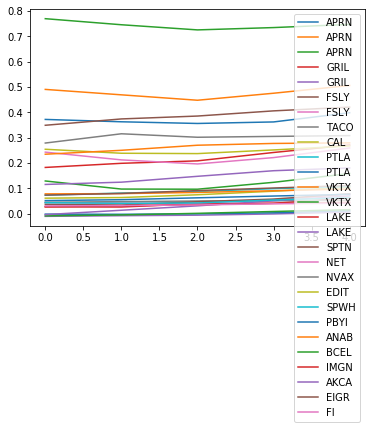

In [42]:
from scipy.stats import linregress
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue

        for trade in trade_details[run_id][symbol]:
            if 'macd1' in trade[4]:
                macd = trade[4]['macd1']
                plt.plot(macd, label=symbol)

    plt.legend()
    plt.show()

APRN analysis for run 111 with profit 73.61


,profit,trade,operation,at,price,qty,indicators
0,-540.60,-540.60,buy,2020-03-18 14:00:11.594082,10.20,53,"{'rsi': 66.34535028435515, 'macd1': [0.37223811695233167, 0.3629350058534282, 0.3562965569200607, 0.36229553217830457, 0.3986605921991142], 'macd2': [0.4114970616669673, 0.4136608402929678, 0.41594960928827085, 0.42044967287125345, 0.43109375428387153], 'sell_macd': [0.206611687336558, 0.20082504420246394, 0.19682473729015015, 0.20108911193912604, 0.22510954527677995], 'macd_signal': [0.4220655476113155, 0.41023943925973805, 0.3994508627918026, 0.39201979666910297, 0.39334795577510523], 'sell_macd_signal': [0.2400527195618392, 0.23220718448996416, 0.22513069505000136, 0.2203223784278263, 0.22127981179761702]}"
1,-265.26,275.34,sell,2020-03-18 14:00:32.847108,10.59,26,"{'rsi': 68.91051859735103, 'macd': [0.206611687336558, 0.20082504420246394, 0.19682473729015015, 0.20108911193912604, 0.2365381167053524], 'scalp': 1, 'bail_out': 0, 'movement': 0.021400778210116794, 'too_close': 0, 'macd_signal': [0.2400527195618392, 0.23220718448996416, 0.22513069505000136, 0.2203223784278263, 0.22356552608333152], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.012972590622020885}"
2,-125.90,139.36,sell,2020-03-18 14:01:26.753763,10.72,13,"{'rsi': 72.02000360932786, 'macd': [0.20082504420246394, 0.19682473729015015, 0.20108911193912604, 0.23809655826379306, 0.2778673403575098], 'scalp': 1, 'bail_out': 0, 'movement': 0.02857142857142864, 'too_close': 0, 'macd_signal': [0.23220718448996416, 0.22513069505000136, 0.2203223784278263, 0.22387721439501965, 0.23467523958751768], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.04319210076999214}"
3,-48.69,77.21,sell,2020-03-18 14:02:25.753918,11.03,7,"{'rsi': 74.96915634007172, 'macd': [0.19682473729015015, 0.20108911193912604, 0.23809655826379306, 0.2663660416562106, 0.31254010609632665], 'scalp': 1, 'bail_out': 0, 'movement': 0.028703703703703582, 'too_close': 0, 'macd_signal': [0.22513069505000136, 0.2203223784278263, 0.22387721439501965, 0.23237497984725783, 0.2484080050970716], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.06413210099925507}"
4,-14.82,33.87,sell,2020-03-18 14:03:17.284435,11.29,3,"{'rsi': 76.94821971612865, 'macd': [0.20108911193912604, 0.23809655826379306, 0.2663660416562106, 0.3042284177846373, 0.3503000301212751], 'scalp': 1, 'bail_out': 0, 'movement': 0.02115211521152126, 'too_close': 0, 'macd_signal': [0.2203223784278263, 0.22387721439501965, 0.23237497984725783, 0.24674566743473372, 0.267456539972042], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.08284349014923309}"
5,31.74,46.56,sell,2020-03-18 14:04:14.947379,11.64,4,"{'rsi': 78.01444690534932, 'macd': [0.23809655826379306, 0.2663660416562106, 0.3042284177846373, 0.3391311989524439, 0.37958620766823437], 'scalp': 0, 'bail_out': 0, 'movement': 0.011018069634200087, 'too_close': 0, 'macd_signal': [0.22387721439501965, 0.23237497984725783, 0.24674566743473372, 0.26522277373827574, 0.2880954605242675], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.09149074714396688}"
6,-557.73,-589.47,buy,2020-03-18 14:24:07.204301,12.03,49,"{'rsi': 69.97753395970466, 'macd1': [0.4906353751567458, 0.4692212737184178, 0.44789431363176924, 0.475539637625058, 0.5061387987294861], 'macd2': [0.5724855673282399, 0.5722655503554055, 0.5713078049512017, 0.5794289551331779, 0.5888528058921505], 'sell_macd': [0.27811077065040024, 0.2642073889266534, 0.250461800714298, 0.26870599430578146, 0.2887832101653043], 'macd_signal': [0.5274197040213446, 0.51578001796075

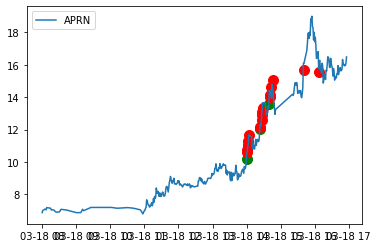

GRIL analysis for run 111 with profit 23.45


,profit,trade,operation,at,price,qty,indicators
0,-490.20,-490.20,buy,2020-03-18 13:48:02.183389,3.80,129,"{'rsi': 58.312796090684685, 'macd1': [0.027174171832581973, 0.02682981900883119, 0.039432621565620884, 0.041582023892841935, 0.06283888299373785], 'macd2': [0.05670114076197219, 0.056267115176767746, 0.05841994951012941, 0.05884857486119888, 0.06316799614603141], 'sell_macd': [0.013852557554295597, 0.01376123795349038, 0.022093180628791842, 0.023561016731250106, 0.0374533433470452], 'macd_signal': [0.027461307627802908, 0.027335009904008563, 0.029754532236331028, 0.03212003056763321, 0.03826380105285414], 'sell_macd_signal': [0.013407715998947963, 0.013478420389856447, 0.015201372437643527, 0.016873301296364843, 0.020989309706500914]}"
1,-244.44,245.76,sell,2020-03-18 13:49:32.332966,3.84,64,"{'rsi': 59.38852943967595, 'macd': [0.022093180628791842, 0.023561016731250106, 0.04186892776262985, 0.0490975736602941, 0.06084590067587303], 'scalp': 1, 'bail_out': 0, 'movement': 0.02362204724409445, 'too_close': 0, 'macd_signal': [0.015201372437643527, 0.016873301296364843, 0.021872426589617845, 0.027317456003753095, 0.03402314493817708], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.02682275573769595}"
2,-123.16,121.28,sell,2020-03-18 13:49:35.212857,3.79,32,"{'rsi': 61.79719244363903, 'macd': [0.022093180628791842, 0.023561016731250106, 0.04186892776262985, 0.0490975736602941, 0.06604070587067801], 'scalp': 1, 'bail_out': 0, 'movement': 0.025641025641025664, 'too_close': 0, 'macd_signal': [0.015201372437643527, 0.016873301296364843, 0.021872426589617845, 0.027317456003753095, 0.035062105977138075], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.030978599893539932}"
3,-10.96,112.20,sell,2020-03-18 14:16:25.619088,3.40,33,"{'rsi': 38.560352265344775, 'macd': [0.02963223903867629, 0.027995061588517167, 0.022480441996334477, 0.013974498911564659, -0.0016661645169775419], 'scalp': 0, 'bail_out': 0, 'movement': -0.13, 'too_close': 1, 'macd_signal': [0.02924633916574068, 0.02899608365029598, 0.02769295531950368, 0.024949264037915874, 0.01962617832693719], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.021292342843914732}"
4,-1030.32,-1019.36,buy,2020-03-18 14:37:59.455190,3.68,277,"{'rsi': 54.65508678233788, 'macd1': [-0.010088291245177405, -0.007527352456037306, -0.005443114345389244, -0.000557251274706072, 0.00646793775531318], 'macd2': [0.021821793284674484, 0.021241178413626827, 0.020671422503216963, 0.02075391189151521, 0.02143635588787962], 'sell_macd': [-0.005315404772835208, -0.003590358247577363, -0.00220473292597978, 0.0009815300898887713, 0.005529507373813747], 'macd_signal': [-0.035230598621894975, -0.029689949388723443, -0.024840582380056604, -0.0199839161589865, -0.014693545376126563], 'sell_macd_signal': [-0.022801197107751043, -0.018959029335716308, -0.015608170053769002, -0.012290230025037447, -0.008726282545267208]}"
5,-516.96,513.36,sell,2020-03-18 14:40:52.470080,3.72,138,"{'rsi': 59.304152393193235, 'macd': [0.0009815300898887713, 0.005597039841346074, 0.01209228068869761, 0.012918542638728603, 0.020563441007081185], 'scalp': 1, 'bail_out': 0, 'movement': 0.032065217391304315, 'too_close': 0, 'macd_signal': [-0.012290230025037447, -0.008712776051760743, -0.0045517647036690725, -0.0010577032351895368, 0.003266525613264608], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.017296915393816576}"
6,-272.01,244.95,sell,2020-03-18 15:12:08.079457,3.55,69,"{'rsi': 61.94078398337604, 'macd': [0.015265244697990177, 0.01248343332273194, 0.01794587337678122, 0.02871730882958845, 0.037781838937885226], 'scalp': 1, 'bail_out': 0, 'movement

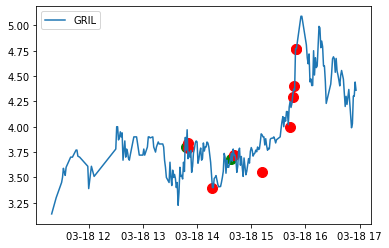

FSLY analysis for run 111 with profit -58.74


,profit,trade,operation,at,price,qty,indicators
0,-1590.16,-1590.16,buy,2020-03-18 13:55:50.134345,15.29,104,"{'rsi': 74.92388950443754, 'macd1': [0.3491751973152972, 0.3741687833869758, 0.3855458803561014, 0.40597242777799636, 0.4207240255840077], 'macd2': [0.08259888405402904, 0.09794622173998668, 0.11111952806882641, 0.126250795462024, 0.14064665435442691], 'sell_macd': [0.22254286847821803, 0.23732136973240614, 0.24318875551836605, 0.2549608904747185, 0.26302020485012534], 'macd_signal': [0.24817517794716745, 0.2733738990351291, 0.29580829529932356, 0.31784112179505813, 0.33841770255284803], 'sell_macd_signal': [0.16129952741995984, 0.1765038958824491, 0.1898408678096325, 0.2028648723426497, 0.21489593884414482]}"
1,-81.12,1509.04,sell,2020-03-18 14:03:07.756188,14.51,104,"{'rsi': 50.52077587263457, 'macd': [0.20795399493852607, 0.1786177358818879, 0.1544775634237041, 0.13314135678844785, 0.1064749443870987], 'scalp': 0, 'bail_out': 0, 'movement': -0.05043657713080343, 'too_close': 1, 'macd_signal': [0.22246887237746446, 0.21369864507834915, 0.20185442874742016, 0.18811181435562568, 0.17178444036192028], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.06530949597482158}"
2,-1610.10,-1528.98,buy,2020-03-18 14:16:05.496961,14.99,102,"{'rsi': 60.26881657107411, 'macd1': [0.04438374366674047, 0.042049972667751234, 0.04133775923358307, 0.05568075145201412, 0.0772363065923578], 'macd2': [0.13859236897572735, 0.13680863967371337, 0.13526861740956697, 0.13671737162810338, 0.1400275331516312], 'sell_macd': [0.01407200041987089, 0.013254847352415666, 0.013484924866705938, 0.02349946676268999, 0.03813028555484976], 'macd_signal': [0.09539728735549001, 0.08472782441794226, 0.07604981138107042, 0.07197599939525916, 0.07302806083467889], 'sell_macd_signal': [0.04582768724765051, 0.03931311926860354, 0.03414748038822402, 0.032017877663117214, 0.03324035924146372]}"
3,-835.92,774.18,sell,2020-03-18 14:16:58.473569,15.18,51,"{'rsi': 65.62998667488678, 'macd': [0.01407200041987089, 0.013254847352415666, 0.013484924866705938, 0.02349946676268999, 0.05423418165874594], 'scalp': 1, 'bail_out': 0, 'movement': 0.020680453635757205, 'too_close': 0, 'macd_signal': [0.04582768724765051, 0.03931311926860354, 0.03414748038822402, 0.032017877663117214, 0.036461138462242956], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.017773043196502983}"
4,-446.92,389.00,sell,2020-03-18 14:29:51.478142,15.56,25,"{'rsi': 70.19600077513995, 'macd': [0.10651650996373263, 0.11064684832914651, 0.11606468538882986, 0.12137644562509209, 0.13225085041146478], 'scalp': 1, 'bail_out': 0, 'movement': 0.023529411764705844, 'too_close': 0, 'macd_signal': [0.0944974013816845, 0.0977272907711769, 0.10139476969470748, 0.1053911048807844, 0.11076305398692048], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.021487796424544306}"
5,-58.74,388.18,sell,2020-03-18 14:41:05.435470,14.93,26,"{'rsi': 42.35388223712222, 'macd': [0.05668471551643606, 0.040858624658721254, 0.026697273020777956, 0.014536514951981161, -0.0003229915295737129], 'scalp': 0, 'bail_out': 0, 'movement': -0.04214559386973181, 'too_close': 1, 'macd_signal': [0.10361221193220801, 0.09106149447751066, 0.07818865018616412, 0.06545822313932753, 0.052301980205547285], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.052624971735121}"


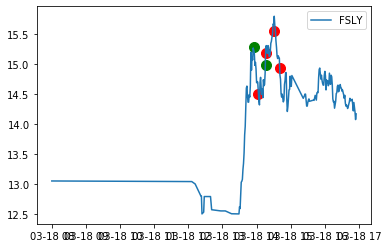

TACO analysis for run 111 with profit 28.1


,profit,trade,operation,at,price,qty,indicators
0,-1149.50,-1149.50,buy,2020-03-18 13:48:01.095132,2.75,418,"{'rsi': 69.13236737493642, 'macd1': [0.045349417123152325, 0.048063109412973315, 0.050439214660976006, 0.05172602971669349, 0.05294246852425877], 'macd2': [0.011177323745778178, 0.013091851311075153, 0.014992275350461437, 0.01671674820660929, 0.01843651831823223], 'sell_macd': [0.028448606408837396, 0.03005952276404722, 0.031443879368573846, 0.032114236730950374, 0.032739005627205664], 'macd_signal': [0.03130678382578707, 0.034658048943224315, 0.037814282086774655, 0.04059663161275842, 0.04306579899505849], 'sell_macd_signal': [0.019708874117481782, 0.02177900384679487, 0.023711978951150663, 0.025392430507110604, 0.026861745531129615]}"
1,-566.39,583.11,sell,2020-03-18 13:55:16.706917,2.79,209,"{'rsi': 73.83641397056961, 'macd': [0.030093323319226428, 0.02900713524981846, 0.028303519413269473, 0.027844812015785703, 0.02952575674481439], 'scalp': 1, 'bail_out': 1, 'movement': 0.02000000000000006, 'too_close': 0, 'macd_signal': [0.028861582405291124, 0.02889069297419659, 0.028773258262011166, 0.028587569012766073, 0.028775206559175738], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007505501856386529}"
2,-279.35,287.04,sell,2020-03-18 13:59:53.577822,2.76,104,"{'rsi': 78.25009622572303, 'macd': [0.03030497752403516, 0.03130893795222889, 0.03168463519559772, 0.03312433908399459, 0.03537444160632974], 'scalp': 1, 'bail_out': 0, 'movement': 0.023172905525846683, 'too_close': 0, 'macd_signal': [0.02893105071501989, 0.02940662816246169, 0.029862229569088898, 0.030514651472070036, 0.03148660949892198], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003887832107407764}"
3,-129.59,149.76,sell,2020-03-18 14:05:17.782888,2.88,52,"{'rsi': 73.06853211422558, 'macd': [0.02889615723268779, 0.027514067661327246, 0.026381087895833932, 0.029830959664335133, 0.03369019792986405], 'scalp': 1, 'bail_out': 0, 'movement': 0.020905923344947754, 'too_close': 0, 'macd_signal': [0.029967484084347955, 0.029476800799743814, 0.028857658218961836, 0.029052318508036495, 0.029979894392402007], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0037103035374620452}"
4,-52.63,76.96,sell,2020-03-18 14:08:15.469051,2.96,26,"{'rsi': 77.1973407296066, 'macd': [0.029830959664335133, 0.03275513299479904, 0.03762130529133234, 0.040924539479652466, 0.04400596171107507], 'scalp': 1, 'bail_out': 0, 'movement': 0.02047781569965872, 'too_close': 0, 'macd_signal': [0.029052318508036495, 0.029792881405389004, 0.03135856618257767, 0.03327176084199263, 0.03541860101580912], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008587360695265951}"
5,28.10,80.73,sell,2020-03-18 14:11:38.151459,2.99,27,"{'rsi': 79.31414206381967, 'macd': [0.040924539479652466, 0.043486481191594706, 0.04476219575685336, 0.04486324352514792, 0.04794375810401208], 'scalp': 0, 'bail_out': 0, 'movement': 0.016722408026755793, 'too_close': 0, 'macd_signal': [0.03327176084199263, 0.03531470491191305, 0.03720420308090111, 0.03873601116975047, 0.04057756055660279], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0073661975474092894}"


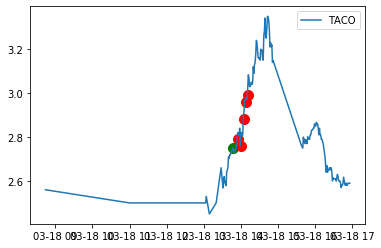

CAL analysis for run 111 with profit 16.56


,profit,trade,operation,at,price,qty,indicators
0,-468.75,-468.75,buy,2020-03-18 13:53:19.239591,3.75,125,"{'rsi': 69.15779156519493, 'macd1': [0.061622679721099693, 0.0642108478375012, 0.075079516899212, 0.08912101525925076, 0.1046906106665828], 'macd2': [-0.01594704198526742, -0.012810824239652963, -0.007985682164635577, -0.002254136925421868, 0.004142225386905896], 'sell_macd': [0.04064235707169406, 0.04198370631060655, 0.04871743680442675, 0.05748764969825526, 0.06721135260645594], 'macd_signal': [0.03538215436885768, 0.041147893062586385, 0.04793421782991151, 0.05617157731577936, 0.06587538398594005], 'sell_macd_signal': [0.024493031726673973, 0.027991166643460488, 0.03213642067565374, 0.037206666480174046, 0.04320760370543043]}"
1,-234.39,234.36,sell,2020-03-18 13:54:05.108244,3.78,62,"{'rsi': 71.42126467253486, 'macd': [0.04198370631060655, 0.04871743680442675, 0.05748764969825526, 0.06721135260645594, 0.07807123341016498], 'scalp': 1, 'bail_out': 0, 'movement': 0.021333333333333353, 'too_close': 0, 'macd_signal': [0.027991166643460488, 0.03213642067565374, 0.037206666480174046, 0.04320760370543043, 0.050180329646377336], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.02789090376378764}"
2,-112.56,121.83,sell,2020-03-18 13:55:04.676820,3.93,31,"{'rsi': 74.09890522938818, 'macd': [0.04871743680442675, 0.05748764969825526, 0.06721135260645594, 0.08196733730626882, 0.09421917814630154], 'scalp': 1, 'bail_out': 0, 'movement': 0.028720626631853752, 'too_close': 0, 'macd_signal': [0.03213642067565374, 0.037206666480174046, 0.04320760370543043, 0.050959550425598105, 0.05961147596973879], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.03460770217656275}"
3,-48.88,63.68,sell,2020-03-18 13:57:12.567538,3.98,16,"{'rsi': 76.15129597460658, 'macd': [0.06721135260645594, 0.08196733730626882, 0.09629710022422344, 0.10673201807945798, 0.11550816162795918], 'scalp': 1, 'bail_out': 0, 'movement': 0.022614213197969475, 'too_close': 0, 'macd_signal': [0.04320760370543043, 0.050959550425598105, 0.06002706038532317, 0.06936805192415013, 0.07859607386491194], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.03691208776304725}"
4,-16.32,32.56,sell,2020-03-18 13:58:22.315459,4.07,8,"{'rsi': 78.3783423668137, 'macd': [0.08196733730626882, 0.09629710022422344, 0.10673201807945798, 0.11295751227730966, 0.12517273486943692], 'scalp': 1, 'bail_out': 0, 'movement': 0.03000670124841793, 'too_close': 0, 'macd_signal': [0.050959550425598105, 0.06002706038532317, 0.06936805192415013, 0.07808594399478204, 0.08750330216971301], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.037669432699723907}"
5,16.56,32.88,sell,2020-03-18 13:59:08.325017,4.11,8,"{'rsi': 78.04486330008822, 'macd': [0.09629710022422344, 0.10673201807945798, 0.11295751227730966, 0.12205585175255429, 0.12963824807414026], 'scalp': 0, 'bail_out': 0, 'movement': -0.0048192771084338455, 'too_close': 0, 'macd_signal': [0.06002706038532317, 0.06936805192415013, 0.07808594399478204, 0.08687992554633649, 0.09543159005189725], 'below_cost_base': 1, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.034206658022243014}"


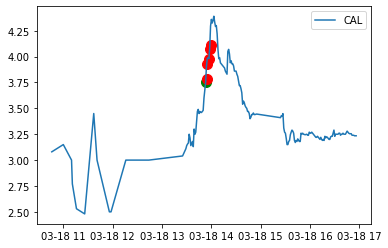

PTLA analysis for run 111 with profit 13.95


,profit,trade,operation,at,price,qty,indicators
0,-1260.00,-1260.00,buy,2020-03-18 13:57:10.182614,6.30,200,"{'rsi': 65.61089546182039, 'macd1': [0.07327910252359615, 0.08188093858893009, 0.08768715273027361, 0.09921410508910089, 0.10791226884500116], 'macd2': [0.07333097490175611, 0.0760706470002539, 0.07846956859587273, 0.08215051234522708, 0.08556564609887918], 'sell_macd': [0.04074435363374018, 0.04637370390510398, 0.0501579547151918, 0.0576501247657113, 0.06325895695097739], 'macd_signal': [0.0883298695813021, 0.08704008338282769, 0.08716949725231687, 0.08957841881967368, 0.09324518882473917], 'sell_macd_signal': [0.051051573440599865, 0.05011599953350069, 0.05012439056983891, 0.05162953740901339, 0.05395542131740619]}"
1,-617.00,643.00,sell,2020-03-18 14:03:18.401482,6.43,100,"{'rsi': 70.2673566971606, 'macd': [0.07200909655657117, 0.07197077284664744, 0.07360362745129567, 0.07443957094256337, 0.0772410909235175], 'scalp': 1, 'bail_out': 0, 'movement': 0.022222222222222313, 'too_close': 0, 'macd_signal': [0.061596056794947424, 0.06367100000528743, 0.06565752549448908, 0.06741393458410394, 0.06937936585198665], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00786172507153085}"
2,3.00,620.00,sell,2020-03-18 14:21:35.439245,6.20,100,"{'rsi': 44.41608818999166, 'macd': [0.022296633564357293, 0.016925536461626756, 0.009663310972984007, 0.0043984169432240705, -2.0960442864037532e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.032608695652173905, 'too_close': 0, 'macd_signal': [0.04093830939477476, 0.03613575480814516, 0.03084126604111293, 0.025552696221535158, 0.02043796488865532], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.020458925331519356}"
3,-2322.05,-2325.05,buy,2020-03-18 14:40:28.222526,6.37,365,"{'rsi': 61.83899876132659, 'macd1': [-0.001384952807173434, -0.00196756473064319, -8.442280590159612e-06, 0.003919741317377934, 0.011739033409035926], 'macd2': [0.06031674544530308, 0.058565767288374815, 0.057340951691315034, 0.056602181401191665, 0.05679157797728873], 'sell_macd': [-0.0028484137227797746, -0.0030458537635391636, -0.0016017050451244685, 0.0011028485672133215, 0.006312853348681813], 'macd_signal': [-0.0041554959358572115, -0.003717909694814407, -0.0029760162119695575, -0.001596864706100059, 0.0010703149169271381], 'sell_macd_signal': [-0.005772490099198462, -0.005227162832066602, -0.004502071274678175, -0.0033810873062998757, -0.001442299175303538]}"
4,13.95,2336.00,sell,2020-03-18 15:12:08.235301,6.40,365,"{'rsi': 38.37908621652674, 'macd': [0.030701734582955886, 0.029767478892318344, 0.01670484486205126, 0.006953378801297205, -0.0007354698019046424], 'scalp': 0, 'bail_out': 0, 'movement': -0.024740973312401947, 'too_close': 1, 'macd_signal': [0.022444818179286164, 0.0239093503218926, 0.02246844922992433, 0.019365435144198907, 0.015345254154978196], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01608072395688284}"


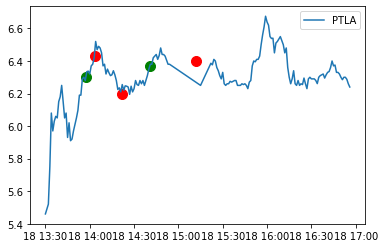

VKTX analysis for run 111 with profit 19.92


,profit,trade,operation,at,price,qty,indicators
0,-1077.44,-1077.44,buy,2020-03-18 13:57:11.958170,4.16,259,"{'rsi': 72.6738551500549, 'macd1': [0.07858724685276286, 0.07958875667432119, 0.0842527457746951, 0.09093532702684337, 0.09752782997907561], 'macd2': [0.05533405854678497, 0.05713031291948445, 0.05965116860117314, 0.06267471288312487, 0.06583603896918566], 'sell_macd': [0.04580148591440514, 0.04635380735394179, 0.049299073315217434, 0.05355124064458572, 0.057727588685072995], 'macd_signal': [0.0841421727070524, 0.08323148950050616, 0.08343574075534395, 0.08493565800964384, 0.08745409240353019], 'sell_macd_signal': [0.050246577635836315, 0.04946802357945741, 0.04943423352660942, 0.050257634950204674, 0.05175162569717834]}"
1,-524.03,553.41,sell,2020-03-18 14:04:44.755527,4.29,129,"{'rsi': 73.6801453518821, 'macd': [0.054447398223492094, 0.05529674741945012, 0.05524043838487902, 0.05811551656073455, 0.06167901232684603], 'scalp': 1, 'bail_out': 0, 'movement': 0.028846153846153872, 'too_close': 0, 'macd_signal': [0.054004287629780746, 0.054262779587714624, 0.0544583113471475, 0.05518975238986491, 0.056487604377261136], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005191407949584892}"
2,2.47,526.50,sell,2020-03-18 14:29:12.628975,4.05,130,"{'rsi': 38.267711563509046, 'macd': [0.01629306072137293, 0.012898293928900628, 0.007664731572053718, 0.0014091669878606439, -0.004262820571093506], 'scalp': 0, 'bail_out': 0, 'movement': -0.05257009345794405, 'too_close': 1, 'macd_signal': [0.02374410995488469, 0.02157494674968788, 0.018792903714161046, 0.015316156368900966, 0.011400360980902071], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01566318155199558}"
3,-1473.80,-1476.27,buy,2020-03-18 14:42:56.892338,4.23,349,"{'rsi': 64.22027050922983, 'macd1': [-0.008172046793799126, -0.004368036995069602, 0.0018529739525963151, 0.00909903125971212, 0.016267890617029046], 'macd2': [0.047259163751699695, 0.04650829783233945, 0.04638283774766183, 0.046673035666161766, 0.04718525208671487], 'sell_macd': [-0.007124752892488928, -0.004445720828211819, -0.00022250466347362163, 0.004629644356628049, 0.009389375484542661], 'macd_signal': [-0.00901731012135516, -0.008087455496098048, -0.006099369606359175, -0.0030596894331449158, 0.000805826576889877], 'sell_macd_signal': [-0.008726778385685833, -0.007870566874191031, -0.006340954432047549, -0.004146834674312429, -0.0014395926425414107]}"
4,19.92,1493.72,sell,2020-03-18 15:12:07.965287,4.28,349,"{'rsi': 38.96660558006288, 'macd': [0.018620244394146113, 0.01824666830307997, 0.010440678254157731, 0.003703014862085574, -0.0015952035585167224], 'scalp': 0, 'bail_out': 0, 'movement': -0.03773584905660381, 'too_close': 1, 'macd_signal': [0.012672602643598475, 0.013787415775494773, 0.013118068271227365, 0.011235057589399007, 0.008669005359815862], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.010264208918332584}"


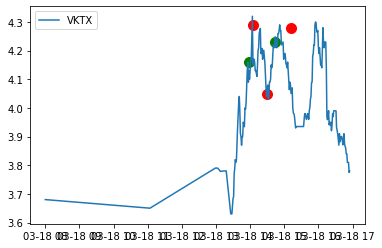

LAKE analysis for run 111 with profit 6.46


,profit,trade,operation,at,price,qty,indicators
0,-1286.64,-1286.64,buy,2020-03-18 13:47:08.713684,17.87,72,"{'rsi': 72.76428225139536, 'macd1': [0.18284594123368691, 0.1991329329567968, 0.2088263545865061, 0.24186562960024816, 0.27147229088338065], 'macd2': [0.06370271695869789, 0.07204030403173078, 0.07943599641034993, 0.09169179176323183, 0.10411954783677402], 'sell_macd': [0.11346520884399425, 0.12348079523599864, 0.12916202105786923, 0.15003100194428853, 0.16856227273962787], 'macd_signal': [0.14180105628683407, 0.15326743162082662, 0.1643792162139625, 0.17987649889121965, 0.19819565728965186], 'sell_macd_signal': [0.08873412606226637, 0.09568345989701282, 0.1023791721291841, 0.11190953809220498, 0.12324008502168957]}"
1,-40.32,1246.32,sell,2020-03-18 14:21:16.489838,17.31,72,"{'rsi': 43.792658752544945, 'macd': [0.016270092694892213, 0.01239995713601516, 0.008703748166290382, 0.004152108083825823, -0.0015212752023003873], 'scalp': 0, 'bail_out': 0, 'movement': -0.03295530726256984, 'too_close': 1, 'macd_signal': [0.028257671512291277, 0.025086128637036055, 0.02180965254288692, 0.0182781436510747, 0.014318259880399684], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01583953508270007}"
2,-2216.19,-2175.87,buy,2020-03-18 14:36:14.580216,17.69,123,"{'rsi': 70.00213604601112, 'macd1': [-0.0032847670100295545, 0.014021604322874026, 0.03140156358001889, 0.05105023178911949, 0.07048949911204261], 'macd2': [0.06443058316401817, 0.06607607824156858, 0.06828238766199135, 0.07148414233042288, 0.07524315909281398], 'sell_macd': [-0.004026666117496802, 0.007488621501021697, 0.0189565258595934, 0.03180740554342165, 0.04442098184843957], 'macd_signal': [-0.024233957023742803, -0.016582844754419436, -0.006985963087531771, 0.004621275887798482, 0.017794920532647307], 'sell_macd_signal': [-0.01945847027441542, -0.014069051919327995, -0.007463936363543716, 0.0003903320178493567, 0.0091964619839674]}"
3,-1116.36,1099.83,sell,2020-03-18 14:43:18.976533,18.03,61,"{'rsi': 77.158212082212, 'macd': [0.048380460128576885, 0.05072151312570483, 0.05656231399196798, 0.068171219680071, 0.08582788359703031], 'scalp': 1, 'bail_out': 0, 'movement': 0.02001353790613703, 'too_close': 0, 'macd_signal': [0.03230316562895927, 0.03598683512830838, 0.0401019309010403, 0.04571578865684644, 0.05373820764488321], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.032089675952147095}"
4,6.46,1122.82,sell,2020-03-18 14:43:58.345749,18.11,62,"{'rsi': 78.3581243424215, 'macd': [0.048380460128576885, 0.05072151312570483, 0.05656231399196798, 0.068171219680071, 0.08879931216845804], 'scalp': 0, 'bail_out': 0, 'movement': 0.003163226933882015, 'too_close': 0, 'macd_signal': [0.03230316562895927, 0.03598683512830838, 0.0401019309010403, 0.04571578865684644, 0.05433249335916876], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.034466818809289285}"


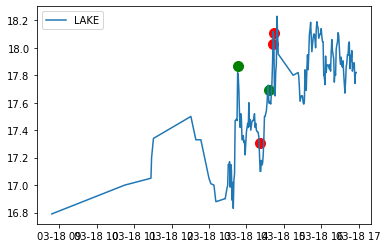

SPTN analysis for run 111 with profit 63.17


,profit,trade,operation,at,price,qty,indicators
0,-2147.62,-2147.62,buy,2020-03-18 14:28:01.529272,12.86,167,"{'rsi': 65.94956319106596, 'macd1': [0.03713517736584038, 0.03479141116197937, 0.04771533893773494, 0.05809487962885207, 0.07912620205489773], 'macd2': [0.212069118991975, 0.20808859333626373, 0.20713235826743848, 0.20608124818089735, 0.2075035075564049], 'sell_macd': [0.007353400485754946, 0.0067694807857225925, 0.016096692957312086, 0.0236750830526109, 0.038104022308004915], 'macd_signal': [0.08319934029420414, 0.07351775446775918, 0.06835727136175433, 0.06630479301517388, 0.06886907482311865], 'sell_macd_signal': [0.034244990410236896, 0.028749888485334035, 0.026219249379729644, 0.025710416114305894, 0.0281891373530457]}"
1,-1059.49,1088.13,sell,2020-03-18 14:45:13.492116,13.11,83,"{'rsi': 71.26019513904046, 'macd': [0.051644642990382295, 0.05156441398635181, 0.052037424970400536, 0.06030162281549778, 0.06855552213874816], 'scalp': 1, 'bail_out': 0, 'movement': 0.021756021756021846, 'too_close': 0, 'macd_signal': [0.05532787751493702, 0.05457518480921998, 0.05406763284145609, 0.05531443083626443, 0.057962649096761173], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.010592873041986986}"
2,-488.29,571.20,sell,2020-03-18 15:42:47.794836,13.60,42,"{'rsi': 76.62428346511038, 'macd': [0.04500735712211146, 0.04809091092681861, 0.05792107089247622, 0.06664689591906026, 0.0887365401486182], 'scalp': 1, 'bail_out': 0, 'movement': 0.03581749049429658, 'too_close': 0, 'macd_signal': [0.04549954410701429, 0.04601781747097515, 0.04839846815527536, 0.05204815370803234, 0.05938583099614951], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.029350709152468693}"
3,63.17,551.46,sell,2020-03-18 16:22:31.174135,13.13,42,"{'rsi': 39.55146025347034, 'macd': [0.022474767043405564, 0.019339044730148913, 0.015086026762286764, 0.009498142283922206, -0.0012131721444657018], 'scalp': 0, 'bail_out': 0, 'movement': -0.031642317010498563, 'too_close': 1, 'macd_signal': [0.02514746804842888, 0.023985783384772887, 0.02220583206027566, 0.01966429410500497, 0.015488800855110833], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.016701972999576535}"


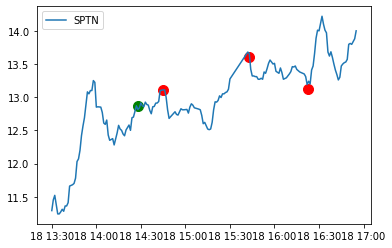

NET analysis for run 111 with profit 26.6


,profit,trade,operation,at,price,qty,indicators
0,-1588.0,-1588.0,buy,2020-03-18 13:53:13.021222,19.85,80,"{'rsi': 68.4419073459626, 'macd1': [0.24319984143411233, 0.21263377038125597, 0.19663318741526936, 0.22169446073348098, 0.25959153286902037], 'macd2': [0.09465139721837446, 0.09483824181803513, 0.0969376326443232, 0.10670130627915242, 0.11968147733418277], 'sell_macd': [0.15289928553776022, 0.1320123301276972, 0.1207755813649527, 0.1363940163372952, 0.16033053688279253], 'macd_signal': [0.20886907854948433, 0.20962201691583865, 0.2070242510157248, 0.20995829295927604, 0.2198849409412249], 'sell_macd_signal': [0.13405083956404568, 0.133643137676776, 0.13106962641441133, 0.1321345043989881, 0.137773710895749]}"
1,-780.0,808.0,sell,2020-03-18 14:27:00.619029,20.20,40,"{'rsi': 66.16685999419416, 'macd': [0.04498022505626764, 0.039703327195312, 0.03845245448293966, 0.04012122309040578, 0.055679728198946066], 'scalp': 1, 'bail_out': 1, 'movement': 0.02267002518891684, 'too_close': 0, 'macd_signal': [0.07343503815105465, 0.06668869595990612, 0.061041447664512825, 0.056857402749691414, 0.056621867839542345], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000942139640596279}"
2,-366.2,413.8,sell,2020-03-18 14:30:20.543104,20.69,20,"{'rsi': 75.23237225960085, 'macd': [0.05516024767946348, 0.07187688699977457, 0.09695638663898265, 0.11731760211577935, 0.13476117778450813], 'scalp': 1, 'bail_out': 0, 'movement': 0.02215270935960591, 'too_close': 0, 'macd_signal': [0.05651797173564583, 0.059589754788471574, 0.06706308115857379, 0.0771139853500149, 0.08864342383691355], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.046117753947594584}"
3,26.6,392.8,sell,2020-03-18 14:37:17.893134,19.64,20,"{'rsi': 40.350342917058356, 'macd': [0.08902464162483525, 0.06460557077091522, 0.03798544321239561, 0.009216701696502128, -0.012800716389861577], 'scalp': 0, 'bail_out': 0, 'movement': -0.05155255256702511, 'too_close': 1, 'macd_signal': [0.10085445302827312, 0.09360467657680153, 0.08248082990392035, 0.06782800426243671, 0.051702260131977054], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.06450297652183863}"


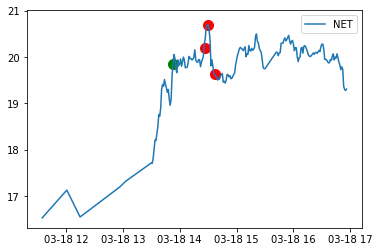

NVAX analysis for run 111 with profit -2.34


,profit,trade,operation,at,price,qty,indicators
0,-848.64,-848.64,buy,2020-03-18 13:58:24.642510,10.88,78,"{'rsi': 64.90752506694619, 'macd1': [0.2790798420939833, 0.31562213216350976, 0.3019020217374866, 0.30526202614174025, 0.3084043426847689], 'macd2': [0.16851962014963995, 0.1818893247584601, 0.1861292819779159, 0.19325108303111982, 0.20029396983291825], 'sell_macd': [0.1683334493087223, 0.1914917685323534, 0.1818139423620373, 0.18334013051033438, 0.18474572996991157], 'macd_signal': [0.25265694336698935, 0.26524998112629344, 0.27258038924853206, 0.2791167166271737, 0.28497424183869274], 'sell_macd_signal': [0.15390696884069738, 0.16142392877902859, 0.16550193149563033, 0.16906957129857114, 0.17220480303283922]}"
1,-415.74,432.90,sell,2020-03-18 14:32:10.379746,11.10,39,"{'rsi': 65.87168836023616, 'macd': [0.062206241268269125, 0.06045162627621892, 0.06008112594116355, 0.06057059157694944, 0.06743808958435515], 'scalp': 1, 'bail_out': 0, 'movement': 0.02022058823529401, 'too_close': 0, 'macd_signal': [0.051994435233901334, 0.05368587344236485, 0.054964923942124586, 0.056086057469089554, 0.058356463892142676], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009081625692212478}"
2,-2.34,413.40,sell,2020-03-18 14:39:07.728034,10.60,39,"{'rsi': 43.02209264306669, 'macd': [0.0465853589459968, 0.04034341668241481, 0.027282897818812657, 0.011556741589787478, -0.0005877534145160013], 'scalp': 0, 'bail_out': 0, 'movement': -0.04459459459459453, 'too_close': 1, 'macd_signal': [0.05706140186561806, 0.05371780482897741, 0.04843082342694446, 0.04105600705951306, 0.03272725496470725], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.03331500837922325}"


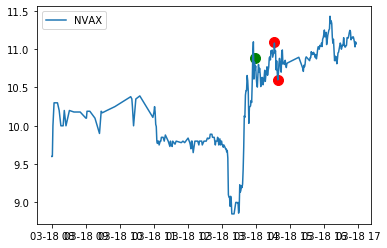

EDIT analysis for run 111 with profit 2.22


,profit,trade,operation,at,price,qty,indicators
0,-2629.96,-2629.96,buy,2020-03-18 13:56:49.163382,17.77,148,"{'rsi': 66.35530143266347, 'macd1': [0.2545506415298071, 0.23881572238881077, 0.23743918206593762, 0.2518907338691996, 0.26752211224646416], 'macd2': [0.20055367154597548, 0.2018357689891097, 0.2054338350189724, 0.21207174569256182, 0.21927908094932036], 'sell_macd': [0.1503190283126763, 0.13964258281990638, 0.13841363071099622, 0.1475337507467671, 0.15739963972598048], 'macd_signal': [0.26733385022171724, 0.26163022465513597, 0.2567920161372963, 0.255811759683677, 0.2581538301962344], 'sell_macd_signal': [0.16100856415019354, 0.1567353678841361, 0.15307102044950813, 0.15196356650895992, 0.15305078115236403]}"
1,-1292.78,1337.18,sell,2020-03-18 13:58:26.148781,18.07,74,"{'rsi': 68.70405999217789, 'macd': [0.1475337507467671, 0.1662308085571489, 0.163835908038525, 0.16997188285468212, 0.1907275530639616], 'scalp': 1, 'bail_out': 0, 'movement': 0.024170882518268676, 'too_close': 0, 'macd_signal': [0.15196356650895992, 0.15481701491859773, 0.15662079354258318, 0.15929101140500296, 0.16557831973679468], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.025149233327166926}"
2,2.22,1295.00,sell,2020-03-18 14:19:29.452929,17.50,74,"{'rsi': 44.00303574133847, 'macd': [0.042089618214433244, 0.03892508233180436, 0.02917446888648456, 0.013405491281218929, -0.00035482232394201674], 'scalp': 0, 'bail_out': 0, 'movement': -0.03704720087815572, 'too_close': 1, 'macd_signal': [0.08360168252687569, 0.07466636248786143, 0.06556798376758606, 0.05513548527031263, 0.044037423751461705], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.04439224607540372}"


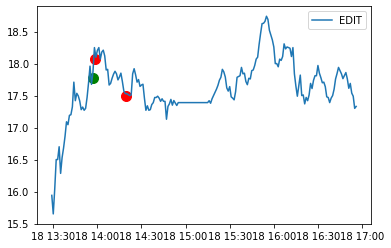

SPWH analysis for run 111 with profit -10.46


,profit,trade,operation,at,price,qty,indicators
0,-1451.86,-1451.86,buy,2020-03-18 14:08:10.647839,6.34,229,"{'rsi': 65.4594836876378, 'macd1': [0.0436883635776697, 0.04134848689107695, 0.042633785932736146, 0.05432302266414801, 0.0636599115828993], 'macd2': [0.0809711548022003, 0.08014643788008602, 0.07997920101910783, 0.08193652656041639, 0.08376621866929579], 'sell_macd': [0.022816923621338248, 0.021458985927560015, 0.02245982686841419, 0.03022074413572451, 0.036395215459138264], 'macd_signal': [0.04467996568727438, 0.04401366992803489, 0.043737693128975144, 0.04585475903600972, 0.04941578954538763], 'sell_macd_signal': [0.02274309370019896, 0.02248627214567117, 0.022480983090219776, 0.024028935299320722, 0.02650219133128423]}"
1,-716.56,735.30,sell,2020-03-18 14:10:28.637210,6.45,114,"{'rsi': 71.45108618288758, 'macd': [0.02245982686841419, 0.03022074413572451, 0.035875734939657455, 0.0398163026448044, 0.049642507315765805], 'scalp': 1, 'bail_out': 0, 'movement': 0.02050473186119872, 'too_close': 0, 'macd_signal': [0.022480983090219776, 0.024028935299320722, 0.02639829522738807, 0.029081896710871337, 0.03319401883185023], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.01644848848391557}"
2,-10.46,706.10,sell,2020-03-18 14:26:07.776193,6.14,115,"{'rsi': 38.01643185763975, 'macd': [0.041928014102459166, 0.03332178525662499, 0.022120544789006047, 0.009115415271523375, -0.0011368339014694584], 'scalp': 0, 'bail_out': 0, 'movement': -0.050231839258114405, 'too_close': 1, 'macd_signal': [0.05109484948459776, 0.04754023663900321, 0.04245629826900378, 0.0357881216695077, 0.028403130555312267], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.029539964456781725}"


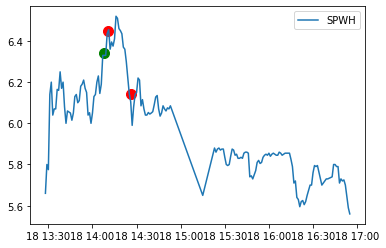

PBYI analysis for run 111 with profit 47.2


,profit,trade,operation,at,price,qty,indicators
0,-1574.12,-1574.12,buy,2020-03-18 14:09:13.241316,6.67,236,"{'rsi': 67.91650287764864, 'macd1': [0.05207125512658983, 0.0556826682011593, 0.06303083892110806, 0.07006395456869008, 0.07677008273054309], 'macd2': [0.05111337836516405, 0.052475235126129505, 0.054677446828038434, 0.057015943165016125, 0.05947608562752116], 'sell_macd': [0.030291104821853487, 0.03263745581332156, 0.03739776235455139, 0.041920108200256045, 0.046198298363139934], 'macd_signal': [0.03961089486173079, 0.04282524952961649, 0.046866367407914805, 0.05150588484006986, 0.05655872441816451], 'sell_macd_signal': [0.021971564115310774, 0.024104742454912932, 0.026763346434840622, 0.029794698787923707, 0.03307541870296695]}"
1,-771.72,802.40,sell,2020-03-18 14:14:38.558786,6.80,118,"{'rsi': 75.41084846805465, 'macd': [0.04905341213924963, 0.05156538935478583, 0.05596997693371186, 0.06075316235971062, 0.06524975928438792], 'scalp': 1, 'bail_out': 0, 'movement': 0.022455089820359337, 'too_close': 0, 'macd_signal': [0.03618790050710656, 0.039263398276642415, 0.04260471400805631, 0.04623440367838717, 0.050037474799587325], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.015212284484800595}"
2,47.20,818.92,sell,2020-03-18 15:24:32.879711,6.94,118,"{'rsi': 31.02238758642898, 'macd': [0.02971621875347008, 0.03171982373571325, 0.033388609127906754, 0.012956641782500888, -0.002613159289016842], 'scalp': 0, 'bail_out': 0, 'movement': -0.043923865300146386, 'too_close': 1, 'macd_signal': [0.0187020847185756, 0.02130563252200313, 0.023722227843183855, 0.021569110631047262, 0.016732656647034442], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.019345815936051284}"


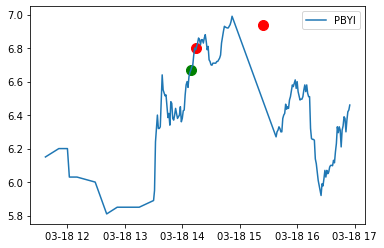

ANAB analysis for run 111 with profit -79.52


,profit,trade,operation,at,price,qty,indicators
0,-1602.72,-1602.72,buy,2020-03-18 14:01:21.349759,14.31,112,"{'rsi': 66.71019558853382, 'macd1': [0.23496850055739849, 0.2504326294197341, 0.2704636975663526, 0.27749130141266143, 0.2798349648089147], 'macd2': [0.11752125810637715, 0.1262586103965937, 0.1362544573291018, 0.1441134841033449, 0.15111355074513888], 'sell_macd': [0.14376030934581507, 0.1531748513541089, 0.1655345613429855, 0.1693793410571356, 0.1701755415998889], 'macd_signal': [0.20081155447546634, 0.21073576946431988, 0.22268135508472642, 0.23364334435031342, 0.24288166844203368], 'sell_macd_signal': [0.1240331288557767, 0.12986147335544315, 0.13699609095295162, 0.14347274097378843, 0.14881330109900853]}"
1,-79.52,1523.20,sell,2020-03-18 14:14:04.747831,13.60,112,"{'rsi': 39.31074222387305, 'macd': [0.09037716395805084, 0.06511973725062603, 0.03991758998184558, 0.018202701331082594, -0.0031102339984876437], 'scalp': 0, 'bail_out': 0, 'movement': -0.04958100558659224, 'too_close': 1, 'macd_signal': [0.13268951728211173, 0.11917556127581459, 0.10332396701702079, 0.08629971387983315, 0.068417724304169], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.07152795830265664}"


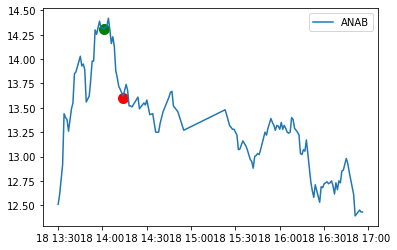

BCEL analysis for run 111 with profit -34.58


,profit,trade,operation,at,price,qty,indicators
0,-1180.27,-1180.27,buy,2020-03-18 14:44:46.717169,12.97,91,"{'rsi': 65.09899162469318, 'macd1': [0.12943990096919578, 0.09756539527393748, 0.09700770112210932, 0.12418320911002567, 0.15881720301383595], 'macd2': [0.048192049286994276, 0.04555036387532141, 0.04816503017369733, 0.05625127049031775, 0.06655972066488225], 'sell_macd': [0.07710127745059125, 0.05600425884031779, 0.0554610721460751, 0.07301883482398885, 0.09536230139348056], 'macd_signal': [0.1533042998179324, 0.14215651890913342, 0.1331267553517286, 0.131338046103388, 0.1368338774854776], 'sell_macd_signal': [0.09509489296659057, 0.08727676614133602, 0.08091362734228383, 0.07933466883862483, 0.08254019534959597]}"
1,-34.58,1145.69,sell,2020-03-18 15:27:30.897037,12.59,91,"{'rsi': 48.88920689297536, 'macd': [0.0546246857582684, 0.03482312893039108, 0.018941095961519494, 0.0022259911031596857, -0.0017367658137850128], 'scalp': 0, 'bail_out': 0, 'movement': -0.04841784216545938, 'too_close': 0, 'macd_signal': [0.08383895209975571, 0.07403578746588278, 0.06301684916501013, 0.05085867755264004, 0.04033958887935503], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.04207635469314004}"


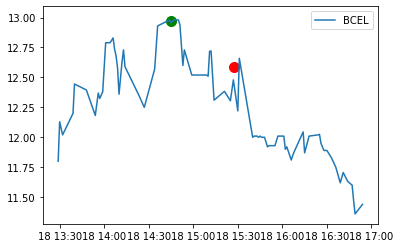

IMGN analysis for run 111 with profit -56.78


,profit,trade,operation,at,price,qty,indicators
0,-858.38,-858.38,buy,2020-03-18 14:05:14.838673,2.57,334,"{'rsi': 68.09672936986179, 'macd1': [0.028142641177824057, 0.03151685023237194, 0.036194457323742935, 0.041042218351754034, 0.045170324930945416], 'macd2': [0.023670541889557306, 0.024818605976993258, 0.026314975845558308, 0.027969468914005535, 0.029606858228216293], 'sell_macd': [0.016277224154816583, 0.018470206104862275, 0.021497591960678797, 0.02461636545922863, 0.027246366036550285], 'macd_signal': [0.02408368854467761, 0.025570320882216478, 0.02769514817052177, 0.030364562206768222, 0.03332571475160366], 'sell_macd_signal': [0.013597626018481057, 0.0145721420357573, 0.015957232020741598, 0.017689058708439002, 0.019600520174061258]}"
1,-56.78,801.60,sell,2020-03-18 14:13:37.559303,2.40,334,"{'rsi': 42.57031461835592, 'macd': [0.02068082353275491, 0.014761625717225169, 0.008918593319186208, 0.003730274654231369, -3.374345682738422e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.06369649805447469, 'too_close': 1, 'macd_signal': [0.024209508218543476, 0.022319931718279815, 0.019639664038461093, 0.016457786161615147, 0.013159480237926641], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013193223694754026}"


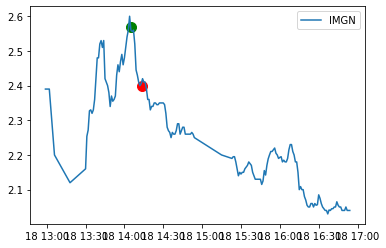

AKCA analysis for run 111 with profit -71.82


,profit,trade,operation,at,price,qty,indicators
0,-1588.02,-1588.02,buy,2020-03-18 14:06:40.924706,11.94,133,"{'rsi': 66.5665584350293, 'macd1': [0.11576838981400783, 0.12472147369122766, 0.14786452831080155, 0.16989553089524634, 0.1808326921121708], 'macd2': [0.05059762907366583, 0.05543954372076065, 0.06332418483554747, 0.07159658086344933, 0.07821329295331125], 'sell_macd': [0.07008760273256698, 0.07564628443384436, 0.09042387687076392, 0.10440091153757436, 0.11107910853070457], 'macd_signal': [0.09986547856005729, 0.10483667758629137, 0.11344224773119341, 0.124732904364004, 0.13595286191363737], 'sell_macd_signal': [0.060846773497703885, 0.06380667568493198, 0.06913011592209836, 0.07618427504519357, 0.08316324174229577]}"
1,-71.82,1516.20,sell,2020-03-18 14:19:58.003622,11.40,133,"{'rsi': 45.288822264248125, 'macd': [0.05129856097052965, 0.030793445630994398, 0.019610323994591283, 0.005446718511750603, -0.00410215223477195], 'scalp': 0, 'bail_out': 0, 'movement': -0.047024552642530276, 'too_close': 0, 'macd_signal': [0.07852399997121838, 0.06897788910317358, 0.05910437608145712, 0.04837284456751582, 0.03787784520705827], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.041979997441830216}"


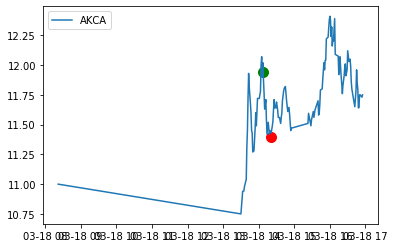

EIGR analysis for run 111 with profit -45.0


,profit,trade,operation,at,price,qty,indicators
0,-882.0,-882.0,buy,2020-03-18 14:07:37.211882,5.88,150,"{'rsi': 70.69267290758509, 'macd1': [0.07382692700766746, 0.0802549764420446, 0.09155609806223097, 0.1017600412340327, 0.11138694780756353], 'macd2': [0.05343125422303974, 0.05612658351782773, 0.05995603028841323, 0.06386316059547603, 0.06791548134484415], 'sell_macd': [0.0436082602323733, 0.04773182540089049, 0.05500042390361948, 0.06150841723167222, 0.06759895206870503], 'macd_signal': [0.05603208837633557, 0.06087666598947737, 0.06701255240402809, 0.07396205017002902, 0.08144702969753592], 'sell_macd_signal': [0.032037258570780935, 0.03517617193680285, 0.03914102233016618, 0.04361450131046739, 0.048411391462114914]}"
1,-45.0,837.0,sell,2020-03-18 14:30:21.810245,5.58,150,"{'rsi': 40.62074563934901, 'macd': [0.019820281137539197, 0.015499207716698216, 0.007775004950891784, 9.673000414700539e-05, -0.005368117097265923], 'scalp': 0, 'bail_out': 0, 'movement': -0.05494505494505497, 'too_close': 1, 'macd_signal': [0.030642555796907167, 0.027613886180865375, 0.02364610993487066, 0.018936233948725928, 0.014075363739527558], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01944348083679348}"


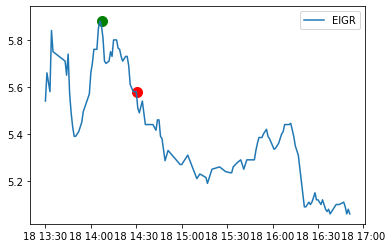

FI analysis for run 111 with profit -80.32


,profit,trade,operation,at,price,qty,indicators
0,-3062.20,-3062.20,buy,2020-03-18 14:05:55.730886,3.05,1004,"{'rsi': 68.89943343371174, 'macd1': [0.031033865239265435, 0.03251402791152769, 0.03489861088368151, 0.03956005211960045, 0.04196363084153587], 'macd2': [0.013920326789631066, 0.015014987974424798, 0.016317968955757323, 0.01813039892865742, 0.019608959413234928], 'sell_macd': [0.01884935021473, 0.019736712834531822, 0.021210804319643284, 0.02416190412207264, 0.025628190927574845], 'macd_signal': [0.026366791146185137, 0.027596238499253647, 0.02905671297613922, 0.031157380804831467, 0.033318630812172345], 'sell_macd_signal': [0.0161204691896695, 0.016843717918641966, 0.01771713519884223, 0.019006088983488312, 0.02033050937230562]}"
1,-80.32,2981.88,sell,2020-03-18 14:24:56.490967,2.97,1004,"{'rsi': 46.06966501614584, 'macd': [0.005939649512014977, 0.00549353403034436, 0.0048148267195577965, 0.004483173922587014, 0.002867818835043945], 'scalp': 0, 'bail_out': 0, 'movement': -0.02622950819672119, 'too_close': 1, 'macd_signal': [0.010303212674216685, 0.00934127694544222, 0.008435986900265336, 0.007645424304729672, 0.006689903210792526], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0038220843757485815}"


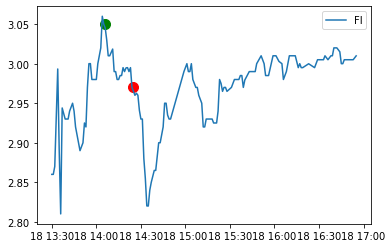

In [44]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
         
        plt.plot(minute_history[symbol]['close'], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
                        
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'qty': qtys,
            'indicators': indicators,
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

CBLI analysis for run 79
buy-price 3.15 sell-price 3.21
buy-price 3.18 sell-price 3.25
buy-price 3.35 sell-price 3.4
buy-price 3.56 sell-price 3.65
buy-price 3.7 sell-price 3.51


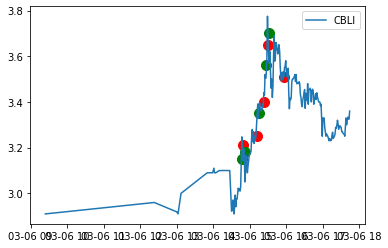

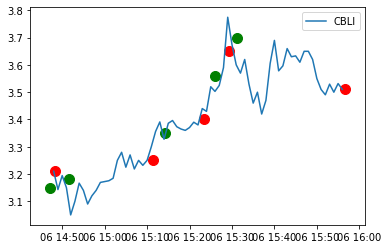

Delta = 0.07999999999999918


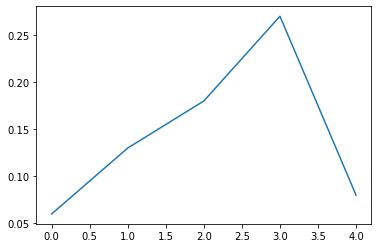

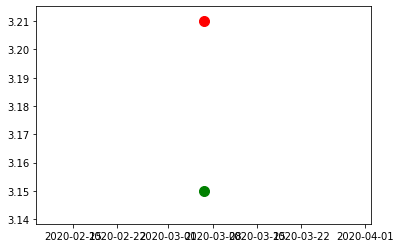

buy time:2020-03-06T14:47:08.303567006Z sell time:2020-03-06T14:48:11.901827542Z
{'rsi': 67.31327161780484, 'macd1': [0.020418625234274845, 0.02111707395653628, 0.02301908279640985, 0.033819584505184075, 0.04189610767296781], 'macd2': [0.003941222317853654, 0.004698837840152681, 0.005708225271359613, 0.008546996793999728, 0.01114508767221567], 'sell_macd': [0.013143788311263727, 0.013509621644135272, 0.014658197986059385, 0.021596592564363082, 0.026722658566101565], 'macd_signal': [0.011772201309258493, 0.013641175838714052, 0.015516757230253211, 0.019177322685239383, 0.023721079682785067], 'sell_macd_signal': [0.007718518970463501, 0.008876739505197856, 0.010033031201370161, 0.012345743473968745, 0.01522112649239531]}
{'rsi': 77.41904708233096, 'macd': [0.013509621644135272, 0.014658197986059385, 0.021596592564363082, 0.0317616196050623, 0.04306213912242507], 'scalp': 1, 'bail_out': 0, 'movement': 0.05396825396825395, 'too_close': 0, 'macd_signal': [0.008876739505197856, 0.01003303120

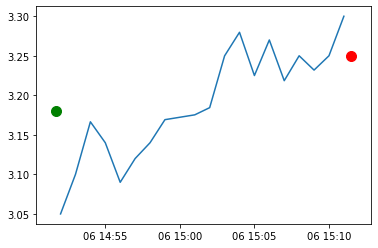

buy time:2020-03-06T14:51:42.942697094Z sell time:2020-03-06T15:11:29.581694155Z
{'rsi': 62.63233131133137, 'macd1': [0.04963399941085944, 0.058507013944811614, 0.05944733001620106, 0.06359091292095087, 0.06564994895263876], 'macd2': [0.012696467120436594, 0.015902043031132074, 0.017754270939323025, 0.02024885683815958, 0.022418807548223896], 'sell_macd': [0.0317616196050623, 0.03734785340813884, 0.03773520632731353, 0.040206712415926216, 0.04130909751853462], 'macd_signal': [0.025268658030363395, 0.03191632921325304, 0.03742252937384265, 0.04265620608326429, 0.047254954657139185], 'sell_macd_signal': [0.016228918700187455, 0.020452705641777733, 0.023909205778884893, 0.02716870710629316, 0.02999678518874145]}
{'rsi': 59.43485964968453, 'macd': [0.03260356843534318, 0.03244369494316013, 0.030957511768171297, 0.030337661089372858, 0.029980145481356413], 'scalp': 0, 'bail_out': 1, 'movement': 0.022456404466189833, 'too_close': 1, 'macd_signal': [0.030512118289903113, 0.030898433620554517,

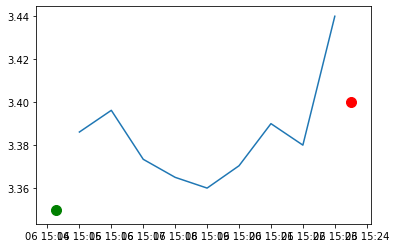

buy time:2020-03-06T15:14:15.545225193Z sell time:2020-03-06T15:23:30.91526561Z
{'rsi': 67.22787809318989, 'macd1': [0.05265545772092084, 0.05181062476705156, 0.05454688812493691, 0.06052034929564565, 0.06557966674511118], 'macd2': [0.038831614577891305, 0.03966199779312163, 0.041162223217780625, 0.04336908839541742, 0.04554442642826828], 'sell_macd': [0.030957511768171297, 0.030337661089372858, 0.03205806755927787, 0.035881006788304415, 0.03909003726821769], 'macd_signal': [0.05201609266392285, 0.05197499908454859, 0.052489376892626255, 0.054095571373230136, 0.05639239044760634], 'sell_macd_signal': [0.030910249250077872, 0.030795731617936868, 0.031048198806205067, 0.03201476040262494, 0.033429815775743485]}
{'rsi': 67.84466896997007, 'macd': [0.040025427815417736, 0.03860590307242884, 0.038016586349678416, 0.036544176093643355, 0.03855860737343875], 'scalp': 0, 'bail_out': 1, 'movement': 0.023981954173097463, 'too_close': 0, 'macd_signal': [0.039574650598898455, 0.03938090109360453, 

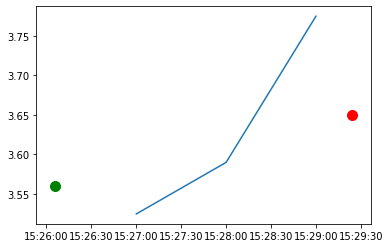

buy time:2020-03-06T15:26:05.426795724Z sell time:2020-03-06T15:29:23.894396471Z
{'rsi': 74.48596728865418, 'macd1': [0.06520395980675131, 0.06304402776216245, 0.0654196476387705, 0.06571371281116978, 0.07629950503671168], 'macd2': [0.05581595196849287, 0.05642702740594263, 0.05785860536353837, 0.05891843201646729, 0.06202558411575643], 'sell_macd': [0.038016586349678416, 0.036544176093643355, 0.03803912685395838, 0.03817494398077548, 0.045016165846077705], 'macd_signal': [0.06629641733219037, 0.06564593941818478, 0.06560068106230192, 0.06562328741207549, 0.06775853093700272], 'sell_macd_signal': [0.03910803814481931, 0.03859526573458412, 0.03848403795845897, 0.03842221916292227, 0.03974100849955336]}
{'rsi': 78.05253469576606, 'macd': [0.04247590610581797, 0.04439255313694446, 0.046441985198381275, 0.050822815568353, 0.0572127766934174], 'scalp': 0, 'bail_out': 0, 'movement': 0.025526072459301174, 'too_close': 0, 'macd_signal': [0.03923295655150141, 0.040264875868590025, 0.04150029773

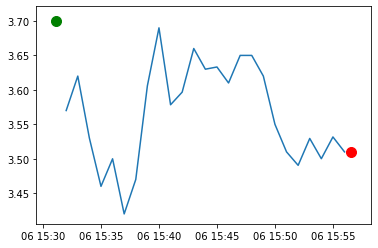

buy time:2020-03-06T15:31:08.527293467Z sell time:2020-03-06T15:56:34.62376587Z
{'rsi': 72.84523698959244, 'macd1': [0.07872864292106785, 0.08559744459225005, 0.10475337245893401, 0.11536096981933941, 0.11981238120063331], 'macd2': [0.06488847544046816, 0.06755316943020917, 0.07285394839569248, 0.07697137206862115, 0.08012623267763086], 'sell_macd': [0.046441985198381275, 0.050822815568353, 0.06318160786224869, 0.0699029835735665, 0.0725754453801315], 'macd_signal': [0.07068467191020014, 0.07366722644661013, 0.0798844556490749, 0.0869797584831278, 0.0935462830266289], 'sell_macd_signal': [0.041500297734548275, 0.04336480130130922, 0.047328162613497114, 0.051843126805510995, 0.0559895905204351]}
{'rsi': 46.56174613526024, 'macd': [0.01038252685814367, 0.00715920153069316, 0.0030272700868265723, 0.0014098264930759719, -0.0015155818461205506], 'scalp': 0, 'bail_out': 0, 'movement': -0.054769363724748804, 'too_close': 0, 'macd_signal': [0.024486876913888934, 0.02102134183724978, 0.01742252

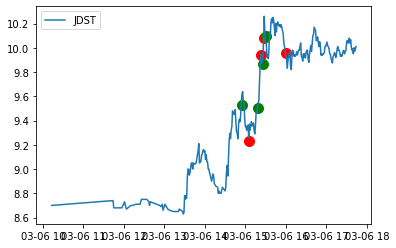

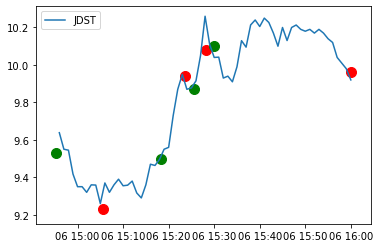

Delta = 0.21000000000000263


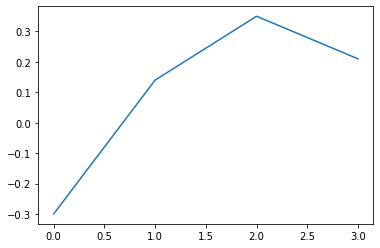

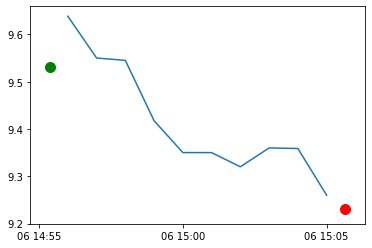

buy time:2020-03-06T14:55:22.128186387Z sell time:2020-03-06T15:05:38.640454153Z
{'rsi': 67.56131316205207, 'macd1': [0.08908507378373187, 0.08930680581784145, 0.08686734452470368, 0.08799463445715006, 0.09501465210271753], 'macd2': [0.05233613231628631, 0.05440017028426247, 0.0558922737161609, 0.057983341649761044, 0.061245882212983105], 'sell_macd': [0.05323296052502435, 0.05314690212053108, 0.05135066307650504, 0.051907481184059634, 0.05631659294080471], 'macd_signal': [0.1012633255030059, 0.09887202156597301, 0.09647108615771914, 0.09477579581760533, 0.09482356707462777], 'sell_macd_signal': [0.06266315055903628, 0.06075990087133524, 0.0588780533123692, 0.05748393888670729, 0.05725046969752677]}
{'rsi': 42.14989384861318, 'macd': [0.037319920498145365, 0.027921685992678746, 0.022308494352150987, 0.017582520419892944, 0.007505365142549181], 'scalp': 0, 'bail_out': 0, 'movement': -0.030430220356768012, 'too_close': 1, 'macd_signal': [0.05498791353933861, 0.04957466803000664, 0.044121

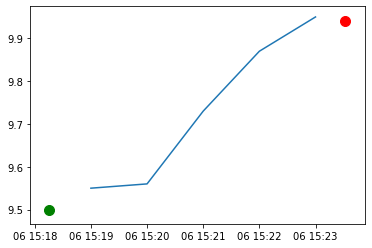

buy time:2020-03-06T15:18:15.345467672Z sell time:2020-03-06T15:23:31.878081929Z
{'rsi': 60.35650889012445, 'macd1': [-0.001553904974450404, -0.0006672799654747763, 0.00880990236310275, 0.015608151738904397, 0.02417876704200772], 'macd2': [0.05094084948405708, 0.04990530486977285, 0.05063205042077357, 0.05111414290824712, 0.05216205903861315], 'sell_macd': [-0.005026899514350092, -0.0041723314557806646, 0.0022620375698014783, 0.00690359736155699, 0.012659311519268357], 'macd_signal': [0.014243653821674158, 0.011261467064244371, 0.010771154124016047, 0.011738553646993718, 0.014226596325996519], 'sell_macd_signal': [0.004348122044988879, 0.0026440313448349703, 0.002567632589828272, 0.0034348255441740156, 0.005279722739192884]}
{'rsi': 78.03319216521943, 'macd': [0.018832061126561328, 0.02434193369848714, 0.037150380719488396, 0.053916048778456016, 0.06940207520390551], 'scalp': 0, 'bail_out': 0, 'movement': 0.044570442759012466, 'too_close': 0, 'macd_signal': [0.007902917689393867, 0.011

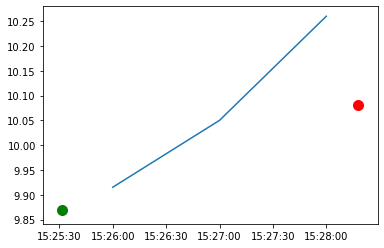

buy time:2020-03-06T15:25:31.228679146Z sell time:2020-03-06T15:28:17.82410727Z
{'rsi': 71.78037161206832, 'macd1': [0.06142062247647573, 0.0872532788695981, 0.11288794380586609, 0.12530384432509756, 0.13439318126381217], 'macd2': [0.05917526853420085, 0.06504215200359909, 0.07161693419275217, 0.07627191463276439, 0.08059099593381802], 'sell_macd': [0.037150380719488396, 0.053916048778456016, 0.07044103624286713, 0.07824698704314947, 0.08382763718566721], 'macd_signal': [0.030452879757680622, 0.04181295958006412, 0.05602795642522451, 0.06988313400519912, 0.08278514345692173], 'sell_macd_signal': [0.016382652856867696, 0.02388933204118536, 0.033199672881521716, 0.04220913571384727, 0.050532836008211256]}
{'rsi': 78.18923948862226, 'macd': [0.07824698704314947, 0.08369776705579568, 0.08881658567531758, 0.0986596055648743, 0.10712092488706304], 'scalp': 0, 'bail_out': 0, 'movement': 0.02125527586311611, 'too_close': 0, 'macd_signal': [0.04220913571384727, 0.05050686198223695, 0.0581688067

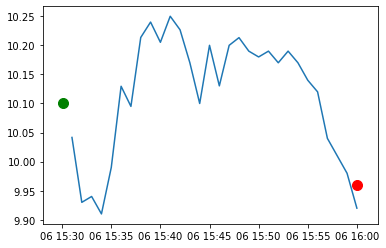

buy time:2020-03-06T15:30:03.479293679Z sell time:2020-03-06T16:00:03.798492387Z
{'rsi': 70.03246129438295, 'macd1': [0.1426369116029722, 0.1583876851120909, 0.1856751836151087, 0.19297250940960708, 0.19569294973966045], 'macd2': [0.08496204704429289, 0.09104199251240352, 0.09984878441647105, 0.10539258011163, 0.11016455275222015], 'sell_macd': [0.08881658567531758, 0.0986596055648743, 0.11595728852342724, 0.12013785591290471, 0.12131572847726524], 'macd_signal': [0.094723588254223, 0.10745640762579659, 0.12310016282365902, 0.13707463214084864, 0.148798295660611], 'sell_macd_signal': [0.058168806720853075, 0.06626696648965733, 0.07620503089641131, 0.08499159589970999, 0.09225642241522104]}
{'rsi': 40.95266042219563, 'macd': [0.030438027267987167, 0.021541916644956416, 0.012771675683568517, 0.004213414211271527, -0.003029561146506765], 'scalp': 0, 'bail_out': 0, 'movement': -0.012871287128712773, 'too_close': 1, 'macd_signal': [0.0475250240098499, 0.0423284025368712, 0.03641705716621066

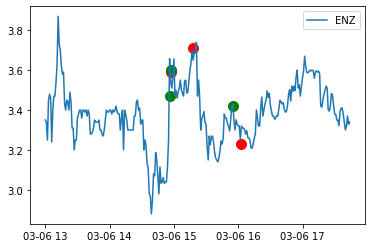

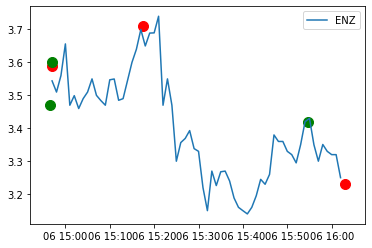

Delta = 0.03999999999999959


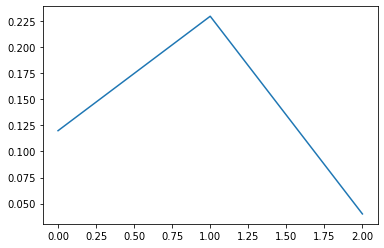

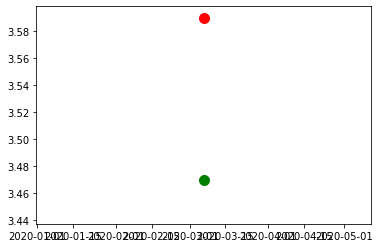

buy time:2020-03-06T14:56:32.420517603Z sell time:2020-03-06T14:56:59.941799023Z
{'rsi': 67.93609746388275, 'macd1': [0.11425770516160494, 0.10583839847020293, 0.10361998555277774, 0.11186914938610215, 0.13540488572974851], 'macd2': [0.13613173427882108, 0.1355341064931288, 0.1358870541297339, 0.13823354924980968, 0.1438498431619628], 'sell_macd': [0.06169998445398939, 0.05636737835952976, 0.05511642064489175, 0.06069857800173395, 0.07620806973431593], 'macd_signal': [0.14971173092328954, 0.14093706443267223, 0.13347364865669334, 0.1291527488025751, 0.13040317618800978], 'sell_macd_signal': [0.08535672312235545, 0.07955885416979032, 0.07467036746481061, 0.07187600957219528, 0.07274242160461941]}
{'rsi': 72.81189317080552, 'macd': [0.06169998445398939, 0.05636737835952976, 0.05511642064489175, 0.06069857800173395, 0.08536131648756218], 'scalp': 1, 'bail_out': 0, 'movement': 0.05063218390804602, 'too_close': 0, 'macd_signal': [0.08535672312235545, 0.07955885416979032, 0.07467036746481061

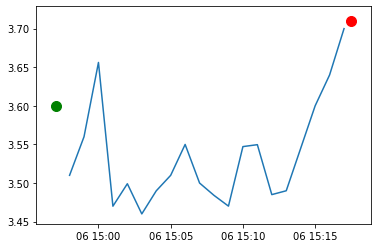

buy time:2020-03-06T14:57:04.348584219Z sell time:2020-03-06T15:17:29.920499982Z
{'rsi': 72.1139695253305, 'macd1': [0.11425770516160494, 0.10583839847020293, 0.10361998555277774, 0.11186914938610215, 0.14714733587219841], 'macd2': [0.13613173427882108, 0.1355341064931288, 0.1358870541297339, 0.13823354924980968, 0.14620410145864415], 'sell_macd': [0.06169998445398939, 0.05636737835952976, 0.05511642064489175, 0.06069857800173395, 0.08385482298106872], 'macd_signal': [0.14971173092328954, 0.14093706443267223, 0.13347364865669334, 0.1291527488025751, 0.13275166621649975], 'sell_macd_signal': [0.08535672312235545, 0.07955885416979032, 0.07467036746481061, 0.07187600957219528, 0.07427177225396997]}
{'rsi': 67.27446121475977, 'macd': [0.05895002700604879, 0.056800851142608355, 0.05724563811729677, 0.05892669760254332, 0.06362717645335181], 'scalp': 0, 'bail_out': 1, 'movement': 0.02558447287163652, 'too_close': 0, 'macd_signal': [0.07561531926593819, 0.07185242564127223, 0.0689310681364771

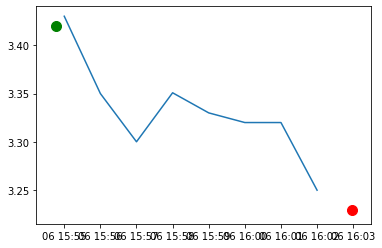

buy time:2020-03-06T15:54:45.977056074Z sell time:2020-03-06T16:02:57.487687874Z
{'rsi': 60.53825868865958, 'macd1': [-0.010708054522318822, -0.007470316714527581, -0.006842797728770389, -0.001885706811396659, 0.008895896691519134], 'macd2': [0.04791382435769265, 0.04664406309297364, 0.04500140138865927, 0.044297774764436415, 0.04495821620330309], 'sell_macd': [-0.005121255328810026, -0.0029896890403944276, -0.0025886024644807826, 0.0006146936007049852, 0.0075807075008405], 'macd_signal': [-0.036742384414549634, -0.03088797087454522, -0.026078936245390254, -0.021240290358591533, -0.0152130529485694], 'sell_macd_signal': [-0.023184260994775014, -0.019145346603898897, -0.015833997776015275, -0.012544259500671224, -0.00851926610036888]}
{'rsi': 42.105642729586556, 'macd': [0.008971270571989987, 0.007950948601385122, 0.006533152928168473, 0.005343530936984475, -2.686971766507895e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.05832023747162567, 'too_close': 1, 'macd_signal': [0.00235397593

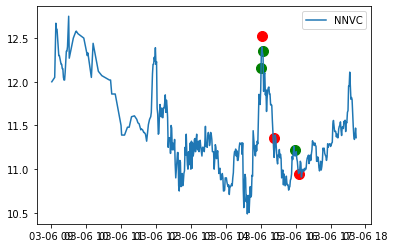

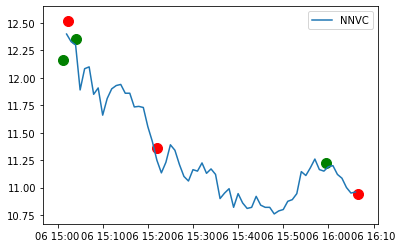

Delta = -0.9100000000000019


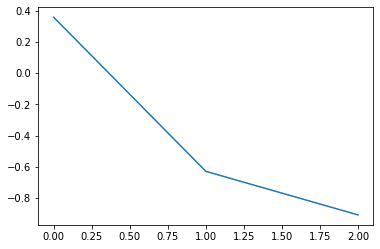

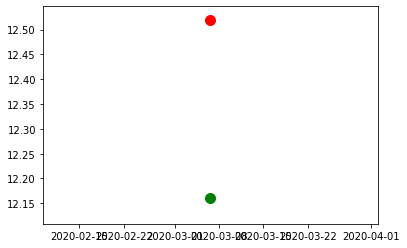

buy time:2020-03-06T15:01:11.316111932Z sell time:2020-03-06T15:02:24.834920627Z
{'rsi': 72.84951848346839, 'macd1': [0.5001259675415817, 0.5051046042724092, 0.49719436690456753, 0.49883626791945446, 0.5160322158038309], 'macd2': [0.47463175203960795, 0.4827988488270911, 0.48832675538954184, 0.4953393127580519, 0.5053283320518975], 'sell_macd': [0.2843296117090226, 0.28754775033649693, 0.28237814731457433, 0.28347744174795153, 0.29471484725775277], 'macd_signal': [0.52695047256861, 0.5225812989093699, 0.5175039125084094, 0.5137703835906184, 0.5142227500332609], 'sell_macd_signal': [0.3036591427767502, 0.30043686428869953, 0.2968251208938745, 0.29415558506468986, 0.2942674375033024]}
{'rsi': 78.02853160438403, 'macd': [0.28754775033649693, 0.28237814731457433, 0.28347744174795153, 0.30094861349151714, 0.32727746662297896], 'scalp': 0, 'bail_out': 0, 'movement': 0.036124794745484363, 'too_close': 0, 'macd_signal': [0.30043686428869953, 0.2968251208938745, 0.29415558506468986, 0.295514190

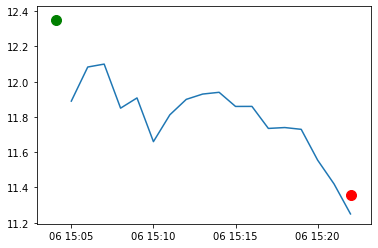

buy time:2020-03-06T15:04:05.407207281Z sell time:2020-03-06T15:22:02.852841229Z
{'rsi': 73.42356667601466, 'macd1': [0.49883626791945446, 0.5256048653764811, 0.5485010045194318, 0.554668623454571, 0.5555729559712255], 'macd2': [0.4953393127580519, 0.5072475643589751, 0.5189788305230252, 0.5278351792320954, 0.5356189128037254], 'sell_macd': [0.28347744174795153, 0.30094861349151714, 0.3158073367528491, 0.31968936349216115, 0.32012095103588223], 'macd_signal': [0.5137703835906184, 0.516137279947791, 0.5226100248621192, 0.5290217445806096, 0.5343319868587327], 'sell_macd_signal': [0.29415558506468986, 0.2955141907500553, 0.2995728199506141, 0.3035961286589235, 0.30690109313431524]}
{'rsi': 39.46152770428804, 'macd': [0.07059970219178524, 0.058265018462989815, 0.03882156336960385, 0.016143266369956777, -0.00244947501119519], 'scalp': 0, 'bail_out': 0, 'movement': -0.07716019417475725, 'too_close': 1, 'macd_signal': [0.12721437430474783, 0.11342450313639622, 0.09850391518303775, 0.08203178

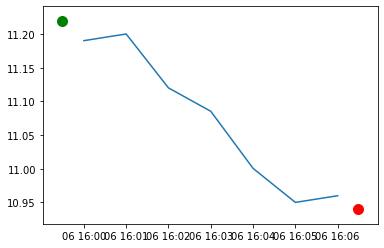

buy time:2020-03-06T15:59:29.452634701Z sell time:2020-03-06T16:06:28.755456342Z
{'rsi': 58.47690323694869, 'macd1': [-0.05280727684544395, -0.030375013579426735, -0.006071958159276747, 0.005379973673141691, 0.0189097781153702], 'macd2': [0.06851083786639478, 0.06845858677163363, 0.06958051235494622, 0.06896604962715003, 0.069216452292018], 'sell_macd': [-0.026322534310871504, -0.011817630378654798, 0.0037942120409777402, 0.010922995588211748, 0.019343826981014445], 'macd_signal': [-0.10692233038589975, -0.09161286702460515, -0.07450468525153947, -0.05852775346660324, -0.043040247150208544], 'sell_macd_signal': [-0.06295313344237646, -0.05272603282963213, -0.04142198385551016, -0.030952987966765776, -0.02089362497720973]}
{'rsi': 42.49887843096418, 'macd': [0.024748749160753647, 0.021888562091415764, 0.014975577854379196, 0.00677097224299672, -0.00023483696383408414], 'scalp': 0, 'bail_out': 0, 'movement': -0.025120523262549148, 'too_close': 1, 'macd_signal': [0.0006877192845680304, 0.

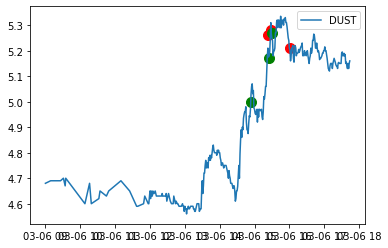

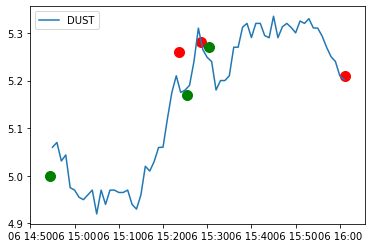

Delta = 0.3100000000000005


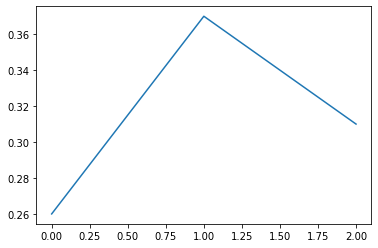

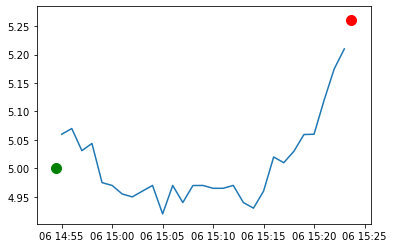

buy time:2020-03-06T14:54:28.894867352Z sell time:2020-03-06T15:23:41.773124594Z
{'rsi': 69.1500452141654, 'macd1': [0.0397468470083977, 0.04060092574595675, 0.04040852674266571, 0.04219045314472858, 0.04549890883700414], 'macd2': [0.020162281739999344, 0.02129988807850669, 0.022232488091536773, 0.023534760253719256, 0.025175059815560452], 'sell_macd': [0.0241027478529654, 0.02453598892075526, 0.024295189896685443, 0.025350473905245252, 0.02740198775730196], 'macd_signal': [0.043055914533059826, 0.042564916775639214, 0.04213363876904451, 0.04214500164418132, 0.04281578308274588], 'sell_macd_signal': [0.026950180119530064, 0.026467341879775102, 0.02603291148315717, 0.025896423967574786, 0.02619753672552022]}
{'rsi': 79.3427895992319, 'macd': [0.01285738264208014, 0.015218431638887253, 0.019977451225504872, 0.026278278809550137, 0.03422855642296785], 'scalp': 0, 'bail_out': 0, 'movement': 0.04800000000000004, 'too_close': 0, 'macd_signal': [0.008505755037226403, 0.009848290357558572, 0.0

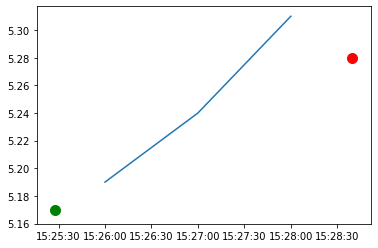

buy time:2020-03-06T15:25:27.605523953Z sell time:2020-03-06T15:28:39.637596161Z
{'rsi': 70.72279939179832, 'macd1': [0.03364253910760162, 0.043347411881660136, 0.053256957082057355, 0.05762190608998097, 0.06038507803533477], 'macd2': [0.032482048364707694, 0.03483040641939272, 0.03749664002920916, 0.03932991351024562, 0.04095368105355757], 'sell_macd': [0.019977451225504872, 0.026278278809550137, 0.03267011486452631, 0.03540829731172224, 0.037082097954838744], 'macd_signal': [0.021558290657805915, 0.02591611490257676, 0.03138428333847288, 0.0366318078887745, 0.041382461918086554], 'sell_macd_signal': [0.011874122531147831, 0.014754953786828293, 0.018337986002367898, 0.021752048264238766, 0.024818058202358762]}
{'rsi': 78.19326117027133, 'macd': [0.03540829731172224, 0.03734183821457915, 0.03888301504518754, 0.04217636043208817, 0.04627278072795793], 'scalp': 0, 'bail_out': 0, 'movement': 0.02028985507246385, 'too_close': 0, 'macd_signal': [0.021752048264238766, 0.024870006254306843, 0

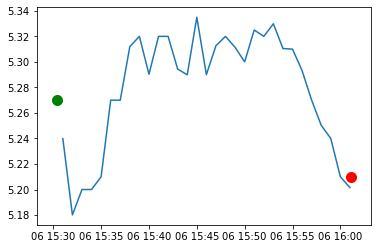

buy time:2020-03-06T15:30:20.328043007Z sell time:2020-03-06T16:01:08.387689553Z
{'rsi': 71.82508486663475, 'macd1': [0.06336634054508306, 0.06865607051179001, 0.07760208606391927, 0.08013697476072768, 0.08160861718972878], 'macd2': [0.04269544871382802, 0.04495575226999993, 0.04808295557814546, 0.05016346856884102, 0.05207734562494526], 'sell_macd': [0.03888301504518754, 0.04217636043208817, 0.04783122228639858, 0.049278761104219804, 0.05002646977909109], 'macd_signal': [0.04584305530730336, 0.05040565834820069, 0.05584494389134441, 0.06070335006522106, 0.0648844034901226], 'sell_macd_signal': [0.02767260801248298, 0.030573358496404017, 0.03402493125440293, 0.03707569722436631, 0.039665851735311265]}
{'rsi': 38.57397800959794, 'macd': [0.012897288530964168, 0.009117435330470158, 0.005518621988131578, 0.0010842398773727169, -0.002644944103444402], 'scalp': 0, 'bail_out': 0, 'movement': -0.012333965844402184, 'too_close': 1, 'macd_signal': [0.020563904658708325, 0.01827461079306069, 0.0

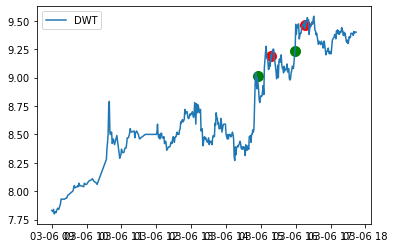

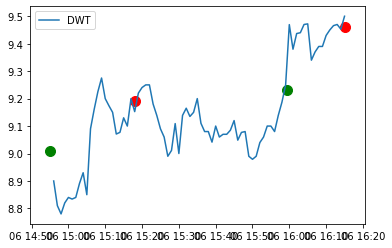

Delta = 0.41000000000000014


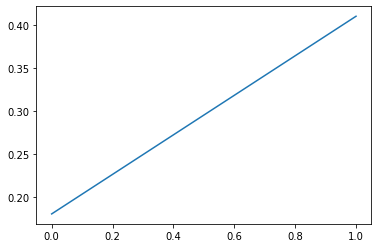

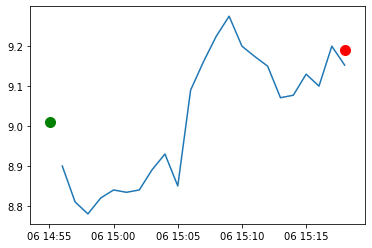

buy time:2020-03-06T14:55:02.962441022Z sell time:2020-03-06T15:18:01.000089835Z
{'rsi': 73.08638284381679, 'macd1': [0.2479058777583525, 0.25800735934137364, 0.25588963283984967, 0.2592117601353543, 0.2596583070462444], 'macd2': [0.15486970055281368, 0.16216273372576495, 0.16719136962982617, 0.1731338429351954, 0.17848414109749555], 'sell_macd': [0.14866798753373445, 0.15476651073553427, 0.1528904702338778, 0.15458588711266863, 0.15441886277000272], 'macd_signal': [0.21751767166158226, 0.22561560919754053, 0.23167041392600235, 0.23717868316787274, 0.24167460794354706], 'sell_macd_signal': [0.1308491491348095, 0.13563262145495444, 0.13908419121073912, 0.14218453039112502, 0.14463139686690057]}
{'rsi': 63.85013696714695, 'macd': [0.0896145624511675, 0.08196348911096507, 0.07768001002624914, 0.07177496125859761, 0.07117654713758803], 'scalp': 0, 'bail_out': 1, 'movement': 0.020532741398446228, 'too_close': 0, 'macd_signal': [0.09672806542705599, 0.0937751501638378, 0.09055612213632007, 0

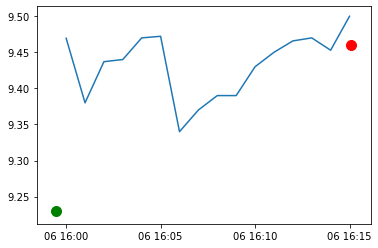

buy time:2020-03-06T15:59:29.218193855Z sell time:2020-03-06T16:15:05.526675028Z
{'rsi': 64.22420211308223, 'macd1': [-0.00474753966200403, -0.002961286217702863, 0.0031545680331603876, 0.011763233693715236, 0.02180406025177284], 'macd2': [0.08512721811834822, 0.08296544627007485, 0.08178267985345933, 0.08133618795260134, 0.08148304016544294], 'sell_macd': [-0.004750791707232693, -0.0034099489408827566, 0.0007284993048575217, 0.006452894050825719, 0.013063423800270257], 'macd_signal': [-0.007035069610306069, -0.006220312931785428, -0.004345336738796265, -0.001123622652293964, 0.0034619139285193964], 'sell_macd_signal': [-0.007302143252065181, -0.006523704389828696, -0.0050732636508914524, -0.002768032110548018, 0.00039825907161563767]}
{'rsi': 64.42632997079926, 'macd': [0.052951440062839694, 0.053150112437105435, 0.05283284269708943, 0.051011167020492465, 0.049298027960540836], 'scalp': 0, 'bail_out': 1, 'movement': 0.02491874322860243, 'too_close': 1, 'macd_signal': [0.05071840173923

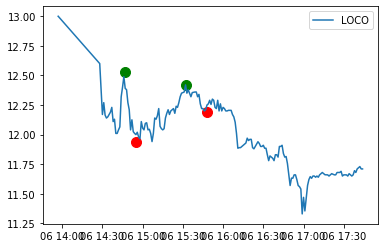

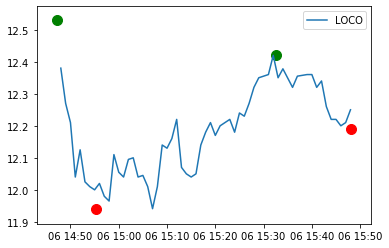

Delta = -0.8200000000000003


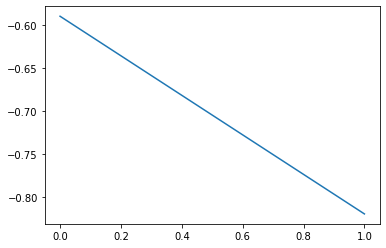

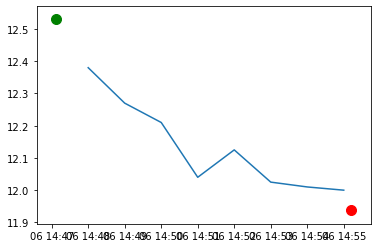

buy time:2020-03-06T14:47:07.052293403Z sell time:2020-03-06T14:55:12.48793624Z
{'rsi': 55.93967697599395, 'macd1': [0.04523006917089667, 0.062194763497741334, 0.08115918482506679, 0.10227194586698829, 0.12083867379593549], 'macd2': [0.012901384804861138, 0.017724696653790062, 0.02341343786841321, 0.0300492394611247, 0.03674607373021033], 'sell_macd': [0.027136922373351524, 0.038045409772598404, 0.050207277748990364, 0.06370734009749057, 0.07547742322492645], 'macd_signal': [0.05540614642760131, 0.056763869841629316, 0.06164293283831681, 0.0697687354440511, 0.07998272311442797], 'sell_macd_signal': [0.034731545511535136, 0.03539431836374779, 0.03835691024079631, 0.04342699621213516, 0.04983708161469342]}
{'rsi': 38.115828980452264, 'macd': [0.04175973895137375, 0.033400874270697045, 0.02125889043808371, 0.010742294069318703, -0.0009685900371128042], 'scalp': 0, 'bail_out': 0, 'movement': -0.04668794892258572, 'too_close': 1, 'macd_signal': [0.05292174129673956, 0.049017567891531055, 0.

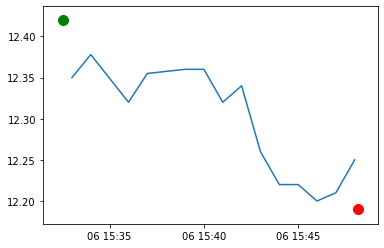

buy time:2020-03-06T15:32:30.902593923Z sell time:2020-03-06T15:48:09.43769019Z
{'rsi': 67.76714140985143, 'macd1': [0.04175220879360708, 0.048913884503807736, 0.05636062319979018, 0.06235039712741397, 0.07111901889831707], 'macd2': [0.025099214654414226, 0.027377408382228907, 0.0299094412227614, 0.032351092482727495, 0.03550536484548239], 'sell_macd': [0.026206101908179846, 0.030731831328052905, 0.03541770059901772, 0.03912853768549596, 0.04462881934138174], 'macd_signal': [0.02793626466346679, 0.03213178863153498, 0.03697755554518602, 0.04205212386163161, 0.0478655028689687], 'sell_macd_signal': [0.017446927546030146, 0.0201039083024347, 0.023166666761751303, 0.026359040946500233, 0.030012996625476535]}
{'rsi': 43.87852830134995, 'macd': [0.019740781330092716, 0.013734573269625017, 0.007837079024200833, 0.0036593292352442575, -0.0001630644864771824], 'scalp': 0, 'bail_out': 0, 'movement': -0.017713365539452547, 'too_close': 0, 'macd_signal': [0.032058833923072114, 0.02839398179238269

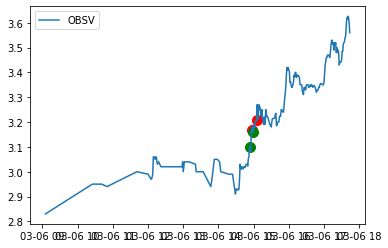

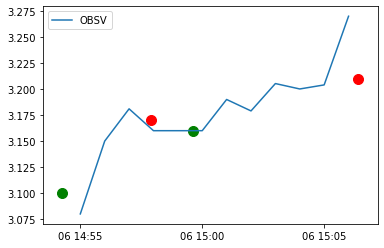

Delta = 0.11999999999999966


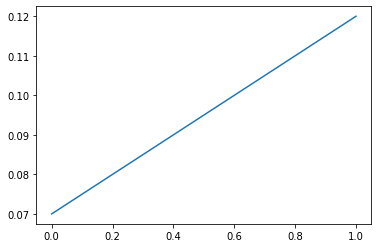

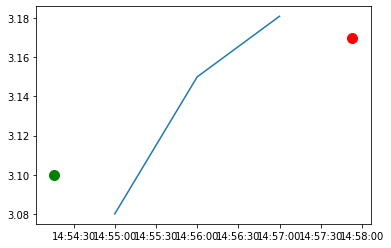

buy time:2020-03-06T14:54:16.044027269Z sell time:2020-03-06T14:57:52.965609138Z
{'rsi': 71.51615708040582, 'macd1': [0.040167506611958004, 0.04039189201265625, 0.04076949434069421, 0.04379161018926325, 0.04566031508270907], 'macd2': [0.02405969077702652, 0.025011903624291065, 0.025980713759060414, 0.02747024165392986, 0.028796720150322752], 'sell_macd': [0.02382930648713799, 0.0238937026201822, 0.024064742430084607, 0.025963413159487914, 0.02710570966084802], 'macd_signal': [0.042686706461914505, 0.042227743572062854, 0.041936093725789124, 0.04230719701848395, 0.042977820631328975], 'sell_macd_signal': [0.025995685687638118, 0.025575289074146933, 0.025273179745334468, 0.025411226428165158, 0.02575012307470173]}
{'rsi': 78.72043014966437, 'macd': [0.025963413159487914, 0.02710570966084802, 0.026604827588390112, 0.029505376264547856, 0.03397975995681923], 'scalp': 0, 'bail_out': 0, 'movement': 0.03225806451612906, 'too_close': 0, 'macd_signal': [0.025411226428165158, 0.02575012307470173

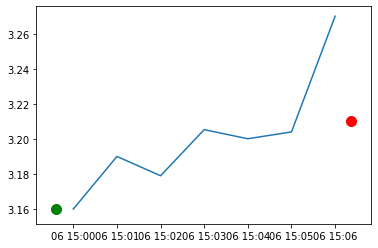

buy time:2020-03-06T14:59:36.147279178Z sell time:2020-03-06T15:06:22.372087835Z
{'rsi': 71.11141183934417, 'macd1': [0.045008613046717105, 0.04956914720032213, 0.055050259175934535, 0.05704201061920999, 0.05795244823865131], 'macd2': [0.029651194416455695, 0.031509467310780526, 0.033664544504142135, 0.035257577068680046, 0.03666682841723157], 'sell_macd': [0.026604827588390112, 0.029505376264547856, 0.03299274696980614, 0.03419079236390665, 0.03468029796497296], 'macd_signal': [0.0433839791144066, 0.04462101273158971, 0.04670686202045867, 0.048773891740208936, 0.05060960303989741], 'sell_macd_signal': [0.02592106397743941, 0.026637926434861098, 0.027908890541850105, 0.029165270906261413, 0.030268276318003724]}
{'rsi': 78.03118745615275, 'macd': [0.03545415528030027, 0.03619444651972392, 0.036031109219019086, 0.035638494319521374, 0.03725933343264609], 'scalp': 0, 'bail_out': 0, 'movement': 0.028481012658227802, 'too_close': 0, 'macd_signal': [0.03272508701701307, 0.03341895891755524, 

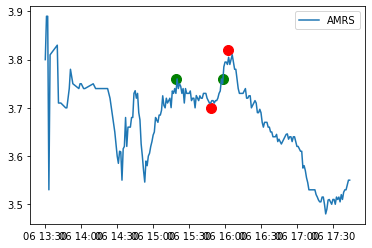

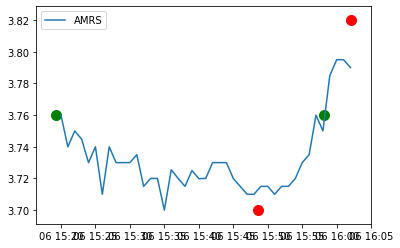

Delta = 4.440892098500626e-16


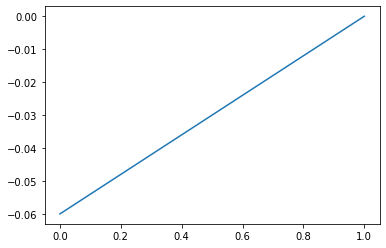

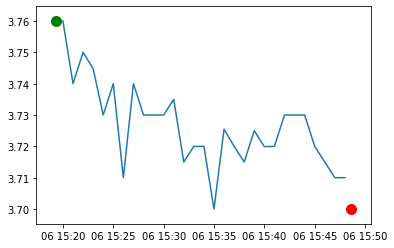

buy time:2020-03-06T15:19:20.537763959Z sell time:2020-03-06T15:48:37.504341685Z
{'rsi': 66.51052118561472, 'macd1': [0.021803479540394743, 0.023324943190118574, 0.02385230139784955, 0.024791373481993784, 0.0276217989213432], 'macd2': [0.014918848491733083, 0.015641375655835343, 0.016201139551067723, 0.016850164806855528, 0.017896948675044655], 'sell_macd': [0.01326108960299388, 0.014199364427708083, 0.01448634007777505, 0.015041303700193964, 0.01682645322805021], 'macd_signal': [0.018837952292697652, 0.019735350472181837, 0.02055874065731538, 0.021405267222251063, 0.02264857356206949], 'sell_macd_signal': [0.011471784499516526, 0.012017300485154838, 0.01251110840367888, 0.013017147462981897, 0.013779008615995559]}
{'rsi': 46.06246857524499, 'macd': [0.0019160283424564106, 0.0015060771592430022, 0.0009073349754498139, 0.00016925879359197538, -0.00040806367010981504], 'scalp': 0, 'bail_out': 0, 'movement': -0.015862910499230748, 'too_close': 1, 'macd_signal': [0.0023327486583087317, 0.0

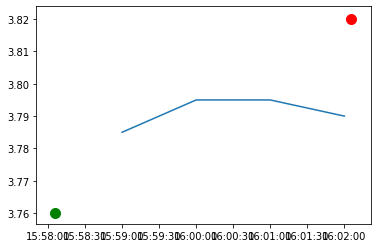

buy time:2020-03-06T15:58:05.965337171Z sell time:2020-03-06T16:02:05.56360768Z
{'rsi': 69.48984233333427, 'macd1': [-0.0008668121660408978, -0.0004983063874051119, 0.0005938084692176382, 0.0018415473629338486, 0.00519129666868956], 'macd2': [0.011469847441044845, 0.0112219741113333, 0.01113591076542697, 0.01111888741397049, 0.011565250356250889], 'sell_macd': [-0.0010785624064224564, -0.0007961834646739163, -4.63273611726045e-05, 0.0007983180098825038, 0.003004557026160537], 'macd_signal': [0.0006591306413953224, 0.00042764323563523557, 0.0004608762823517161, 0.0007370104984681426, 0.0016278677325124262], 'sell_macd_signal': [-0.0002684438160666096, -0.00037399174578807095, -0.00030845886886497764, -8.710349311548136e-05, 0.0005312286107397224]}
{'rsi': 78.09525431385781, 'macd': [0.003706441553769313, 0.006225805783472982, 0.008627572640599546, 0.010387032884586311, 0.012921845634646267], 'scalp': 0, 'bail_out': 0, 'movement': 0.014608233731739632, 'too_close': 0, 'macd_signal': [0.0

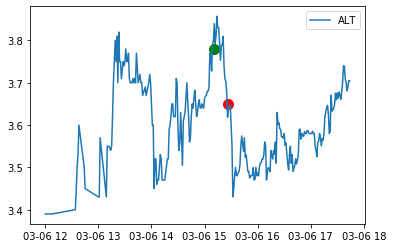

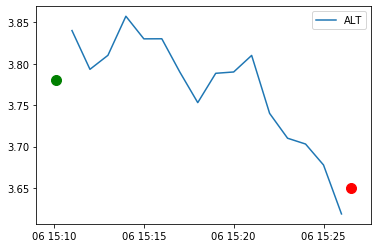

Delta = -0.1299999999999999


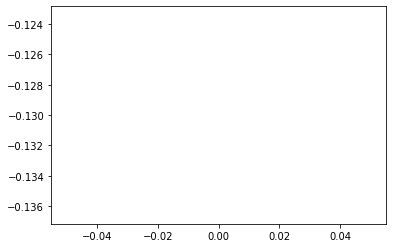

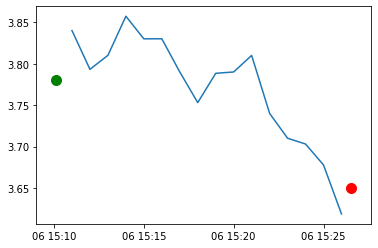

buy time:2020-03-06T15:10:06.900512149Z sell time:2020-03-06T15:26:32.71914146Z
{'rsi': 67.36778174809145, 'macd1': [0.03662018254698962, 0.040551612029176454, 0.040321801942238444, 0.04464406695170586, 0.04752169262064232], 'macd2': [0.06002824053661415, 0.060656901493159054, 0.060567305833437945, 0.06138280809799124, 0.06203492304335123], 'sell_macd': [0.020218683306495677, 0.022843713034083724, 0.022737973691501878, 0.025591449870119742, 0.027482581309690612], 'macd_signal': [0.03408598042537293, 0.035379106746133634, 0.0363676457853546, 0.03802293001862485, 0.039922682539028344], 'sell_macd_signal': [0.018193892032190892, 0.01912385623256946, 0.019846679724355942, 0.020995633753508703, 0.022293023264745086]}
{'rsi': 38.708184634439604, 'macd': [0.01741219546558037, 0.01215497007183508, 0.00753693768616559, 0.002526302870239139, -0.002522585335291261], 'scalp': 0, 'bail_out': 0, 'movement': -0.035277044854881305, 'too_close': 1, 'macd_signal': [0.024557091271579536, 0.02207666703163

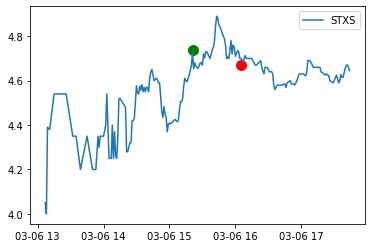

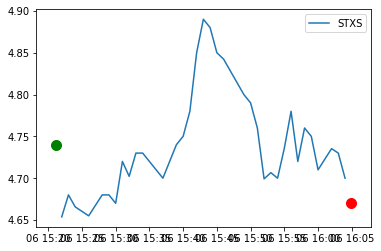

Delta = -0.07000000000000028


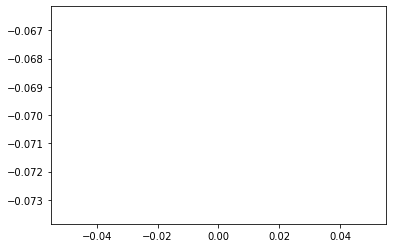

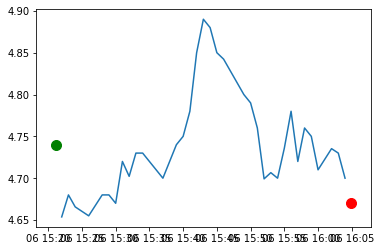

buy time:2020-03-06T15:21:12.153050986Z sell time:2020-03-06T16:04:54.936891225Z
{'rsi': 74.06449581751097, 'macd1': [0.03459175575178808, 0.038117643303752224, 0.04283886411165927, 0.04963937768923099, 0.05998577006266448], 'macd2': [0.07954108237986368, 0.07952611495325002, 0.07986496161120638, 0.08076869064499803, 0.08259052420924196], 'sell_macd': [0.018071739282876642, 0.0205494421734711, 0.023771685436615897, 0.028311463493135847, 0.03511763518012412], 'macd_signal': [0.022442408427004373, 0.025577455402353944, 0.029029737144215008, 0.03315166525321821, 0.038518486215107464], 'sell_macd_signal': [0.008858631399707693, 0.011196793554460373, 0.013711771930891478, 0.016631710243340352, 0.020328895230697107]}
{'rsi': 45.7713549598464, 'macd': [0.006823494564486943, 0.003989737281324679, 0.0030440856674145422, 0.0019923560245311833, -0.00041148987933326], 'scalp': 0, 'bail_out': 0, 'movement': -0.008438818565400852, 'too_close': 1, 'macd_signal': [0.0145483012643654, 0.012436588467757

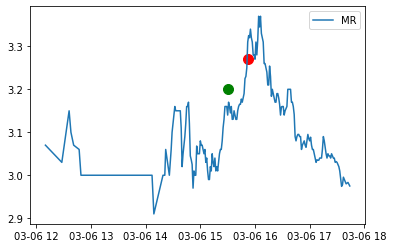

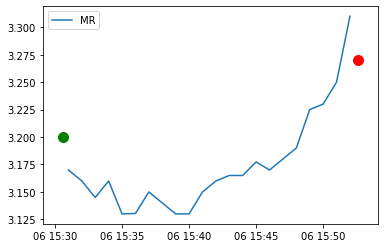

Delta = 0.06999999999999984


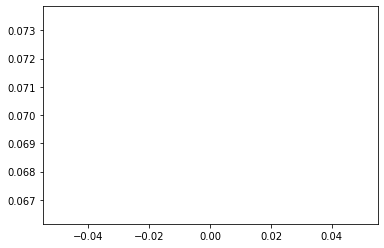

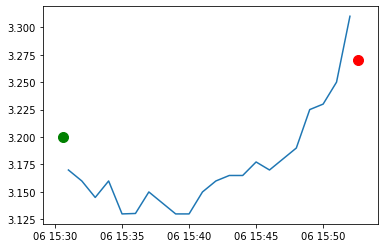

buy time:2020-03-06T15:30:34.276388316Z sell time:2020-03-06T15:52:34.330171171Z
{'rsi': 74.51758825540834, 'macd1': [0.011564252446916612, 0.016765559496481952, 0.023042759498318244, 0.027698198137952712, 0.03501857658053886], 'macd2': [0.018559360644831102, 0.019512473327220725, 0.02083796808486582, 0.022024138242803026, 0.02387990832694653], 'sell_macd': [0.007067666058639954, 0.010448526856855711, 0.014505710246934367, 0.01747876600223064, 0.022165838460873832], 'macd_signal': [0.003167528073907012, 0.005887134358422001, 0.00931825938640125, 0.012994247136711542, 0.017399113025477007], 'sell_macd_signal': [0.0013644901200345163, 0.0031812974673987556, 0.005446180023305878, 0.007852697219090831, 0.010715325467447431]}
{'rsi': 78.92283109054445, 'macd': [0.01463043641772055, 0.016621767803422838, 0.018217327742886535, 0.02026299356918404, 0.023152304686179903], 'scalp': 0, 'bail_out': 0, 'movement': 0.021806853582554468, 'too_close': 0, 'macd_signal': [0.014473746487928596, 0.0149033

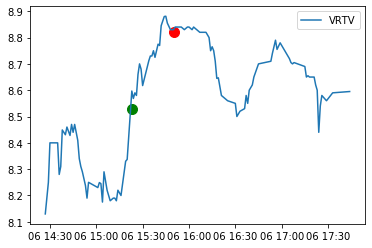

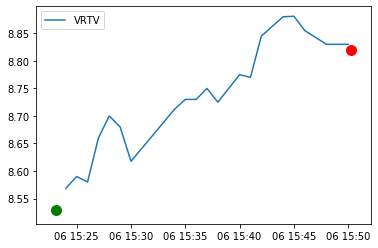

Delta = 0.2900000000000009


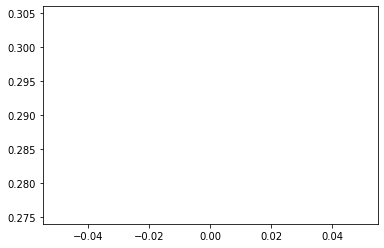

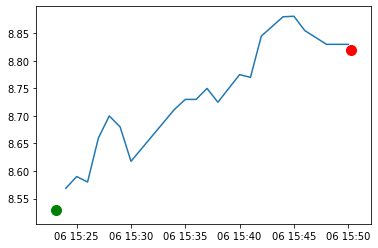

buy time:2020-03-06T15:23:07.40208215Z sell time:2020-03-06T15:50:16.300304537Z
{'rsi': 69.56549051852127, 'macd1': [-0.006102300698190177, -0.007431379896306822, 0.001982377198006091, 0.009893641278187815, 0.03137518844894949], 'macd2': [0.02871088619079032, 0.02770446137506255, 0.028813377270109797, 0.029899487612143005, 0.0339376891101697], 'sell_macd': [-0.00778951708743314, -0.008373284616697063, -0.0019661776964259303, 0.003415544289454786, 0.017590710196770942], 'macd_signal': [0.010697301182348067, 0.007071564966617089, 0.006053727412894889, 0.006821710185953475, 0.011732405838552677], 'sell_macd_signal': [0.002349811855776691, 0.00020519256128194007, -0.000229081490259634, 0.0004998436656832501, 0.003918016971900789]}
{'rsi': 69.38739469128447, 'macd': [0.0777250274218595, 0.07845041954267984, 0.07664617418821962, 0.07294616255892272, 0.06963516437299155], 'scalp': 0, 'bail_out': 1, 'movement': 0.03634232121922632, 'too_close': 1, 'macd_signal': [0.07333624258447145, 0.0743590

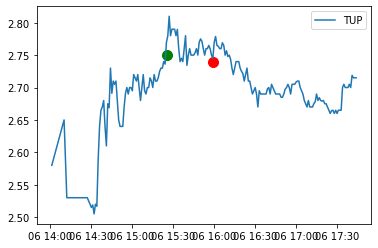

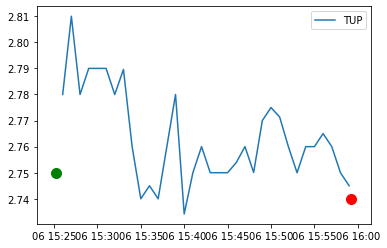

Delta = -0.009999999999999787


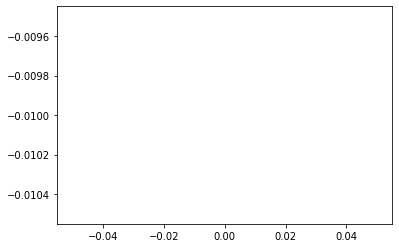

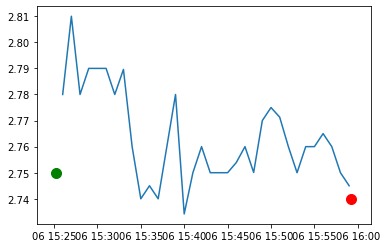

buy time:2020-03-06T15:25:17.26478908Z sell time:2020-03-06T15:59:14.779303772Z
{'rsi': 68.76919816005015, 'macd1': [0.01090478307992182, 0.01142313989185828, 0.012496802466544832, 0.012892443486979932, 0.015751792508836626], 'macd2': [0.010617095470655702, 0.010872484067597998, 0.0112499967526416, 0.011518552011047678, 0.01228779289131543], 'sell_macd': [0.006170515765082207, 0.006513830477807403, 0.007216233754245405, 0.007472441063752555, 0.009330882589813072], 'macd_signal': [0.010424482016782366, 0.010624213591797549, 0.010998731366747005, 0.011377473790793591, 0.012252337534402198], 'sell_macd_signal': [0.0058324387220476765, 0.005968717073199622, 0.006218220409408779, 0.006469064540277534, 0.007041428150184641]}
{'rsi': 44.692098348421716, 'macd': [0.0016098715471328795, 0.0017473091704229837, 0.0015719708357084805, 0.0008954478367657615, -5.892654990091728e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.010108303249097481, 'too_close': 1, 'macd_signal': [0.002236783386524847, 0

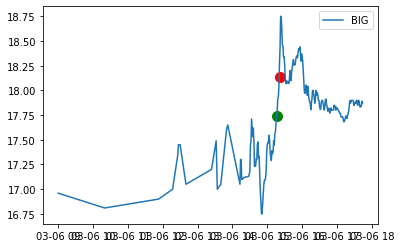

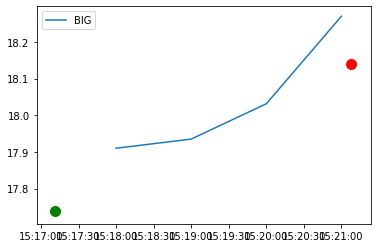

Delta = 0.40000000000000213


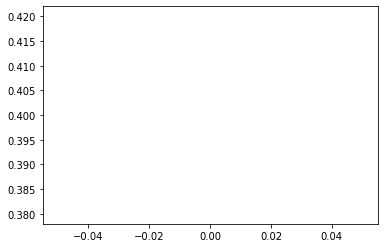

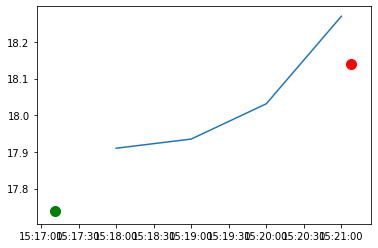

buy time:2020-03-06T15:17:11.601215202Z sell time:2020-03-06T15:21:07.975607336Z
{'rsi': 68.27796443135674, 'macd1': [0.08650338963177973, 0.09441697626914802, 0.10113654441786579, 0.11163037650682739, 0.12496166516334384], 'macd2': [0.10862748512777998, 0.11065492804940291, 0.1126631353466685, 0.1156100495608321, 0.11941589098767835], 'sell_macd': [0.04989937538703515, 0.05502329233059555, 0.05934032771089548, 0.06608944193306598, 0.0746460316914721], 'macd_signal': [0.0857707457566639, 0.08749999185916071, 0.09022730237090174, 0.09450791719808686, 0.10059866679113826], 'sell_macd_signal': [0.04942919071169932, 0.05054801103547857, 0.05230647437056195, 0.055063067883062755, 0.05897966064474462]}
{'rsi': 78.30341799388174, 'macd': [0.08242199732540456, 0.09416402252944067, 0.10338944447375908, 0.11423796229434657, 0.1252960545922832], 'scalp': 0, 'bail_out': 0, 'movement': 0.02085682074408123, 'too_close': 0, 'macd_signal': [0.06366812798087661, 0.06976730689058942, 0.07649173440722336

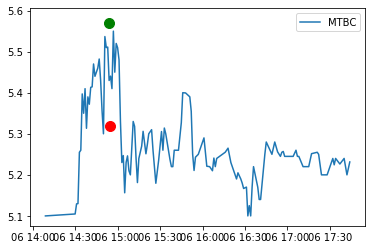

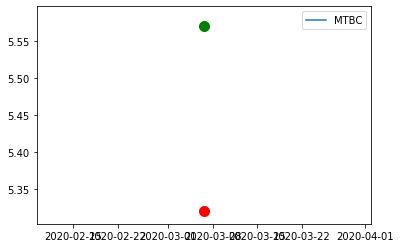

Delta = -0.25


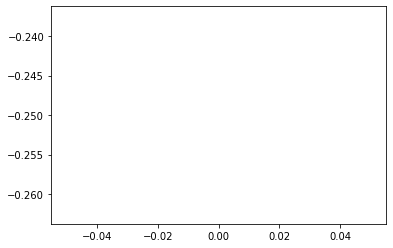

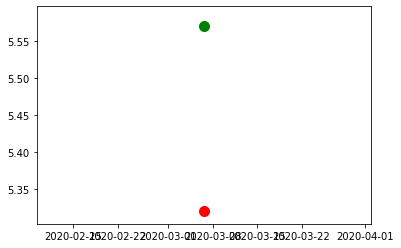

buy time:2020-03-06T14:53:34.457576158Z sell time:2020-03-06T14:54:23.775923924Z
{'rsi': 66.58968563528605, 'macd1': [0.06787404713939171, 0.05482287960820287, 0.06286287223068321, 0.0662997567955248, 0.07522495402671936], 'macd2': [0.04059645840633763, 0.03948874430235794, 0.04219374025179068, 0.04418471215048658, 0.047346842294548], 'sell_macd': [0.040676236700316615, 0.032012225273365225, 0.0371466030540093, 0.03926759089536791, 0.04496098933155146], 'macd_signal': [0.07165779415471339, 0.06829081124541128, 0.06720522344246567, 0.06702413011307749, 0.06866429489580586], 'sell_macd_signal': [0.04405708376706876, 0.04164811206832805, 0.0407478102654643, 0.04045176639144502, 0.04135361097946631]}
{'rsi': 46.61586032892438, 'macd': [0.032012225273365225, 0.0371466030540093, 0.03926759089536791, 0.04047787244843448, 0.03044331427616953], 'scalp': 0, 'bail_out': 0, 'movement': -0.05136221527467629, 'too_close': 1, 'macd_signal': [0.04164811206832805, 0.0407478102654643, 0.0404517663914450

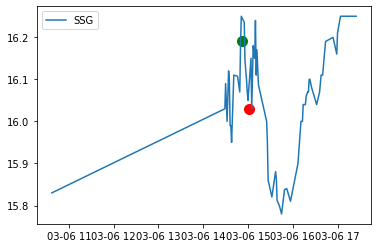

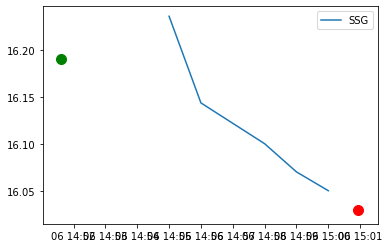

Delta = -0.16000000000000014


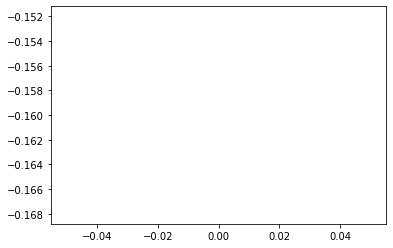

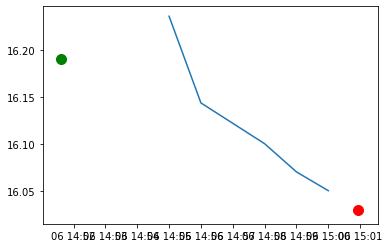

buy time:2020-03-06T14:51:35.993525234Z sell time:2020-03-06T15:00:56.094021699Z
{'rsi': 71.27148562503791, 'macd1': [0.21692807964195993, 0.22240553487308468, 0.2211869538162965, 0.2264865047966893, 0.22965297345885816], 'macd2': [0.12291156684325522, 0.12870646879825642, 0.1332355545732522, 0.13894866298987552, 0.14430254856152303], 'sell_macd': [0.13422517771372533, 0.1371634326022999, 0.13573397624791106, 0.13857162095555786, 0.14002210227378242], 'macd_signal': [0.16293723656896114, 0.17483089622978584, 0.18410210774708796, 0.19257898715700822, 0.1999937844173782], 'sell_macd_signal': [0.10047110746906482, 0.10780957249571184, 0.11339445324615169, 0.11842988678803293, 0.12274832988518283]}
{'rsi': 59.33323855606564, 'macd': [0.14317344682010003, 0.13695608409431692, 0.12807818996910747, 0.11793855571609768, 0.10746691141873832], 'scalp': 0, 'bail_out': 0, 'movement': -0.009259259259259172, 'too_close': 1, 'macd_signal': [0.12724893768775064, 0.12919036696906389, 0.1289679315690726

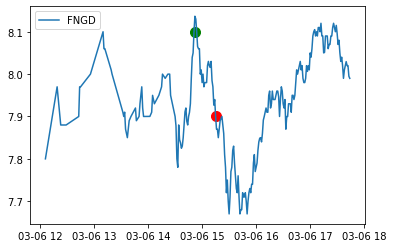

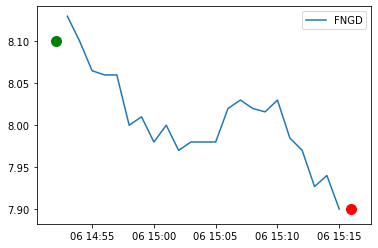

Delta = -0.1999999999999993


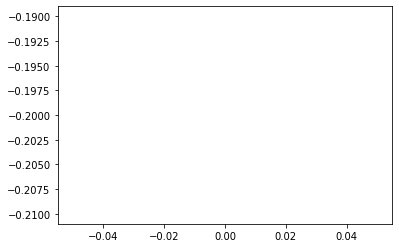

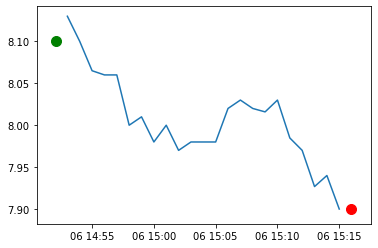

buy time:2020-03-06T14:52:06.02201478Z sell time:2020-03-06T15:15:59.19017842Z
{'rsi': 72.57565179030038, 'macd1': [0.13753292098875036, 0.14017587845118662, 0.14149470975707068, 0.14490411081145727, 0.1459239650755899], 'macd2': [0.09520184014378597, 0.09847665274328854, 0.10150161762952692, 0.10492202455984145, 0.10790110022893895], 'sell_macd': [0.08140348504820594, 0.0828701614453431, 0.08348743965810801, 0.08548158580236542, 0.0859253154498072], 'macd_signal': [0.142921134683533, 0.14237208343706373, 0.14219660870106512, 0.14273810912314355, 0.14337528031363284], 'sell_macd_signal': [0.08651661166509739, 0.08578732162114652, 0.08532734522853883, 0.08535819334330415, 0.08547161776460475]}
{'rsi': 36.63903062142053, 'macd': [0.01653015517120693, 0.013079184889389417, 0.007976101749148867, 0.004581801876894609, -0.00020053311287338005], 'scalp': 0, 'bail_out': 0, 'movement': -0.02469135802469127, 'too_close': 1, 'macd_signal': [0.026230172342100573, 0.02359997485155834, 0.02047520023

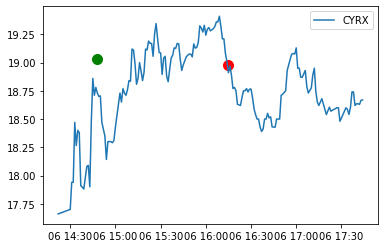

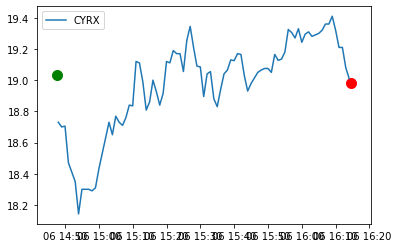

Delta = -0.05000000000000071


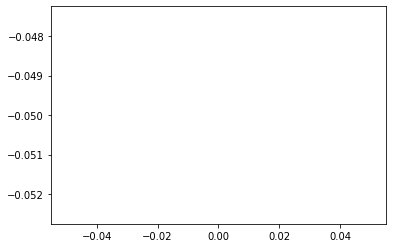

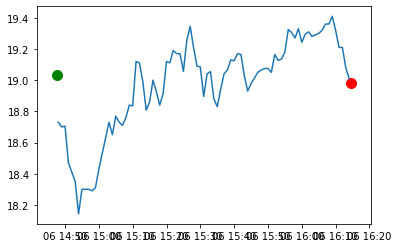

buy time:2020-03-06T14:47:29.941308912Z sell time:2020-03-06T16:14:37.536392713Z
{'rsi': 71.70402080722378, 'macd1': [0.18168185238159396, 0.2094883323178358, 0.2592000948625497, 0.28323637497749843, 0.32435954173448067], 'macd2': [0.09806583155626214, 0.10796925304954641, 0.12298560484636667, 0.13420698951853538, 0.14943273049118133], 'sell_macd': [0.10909526653268031, 0.12672256467701715, 0.15855263381965656, 0.1735091469980823, 0.19952838912415416], 'macd_signal': [0.1977370284883077, 0.20008728925421332, 0.2119098503758806, 0.22617515529620416, 0.24581203258385947], 'sell_macd_signal': [0.12237940806463013, 0.12324803938710753, 0.13030895827361733, 0.13894899601851032, 0.15106487463963908]}
{'rsi': 36.37302714966857, 'macd': [0.04222096207931614, 0.03332894296383415, 0.025967253484708408, 0.013140388260911351, -0.0006615896830979295], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010509721492380228, 'too_close': 1, 'macd_signal': [0.04204673182500167, 0.04030317405276816, 0.0374359899

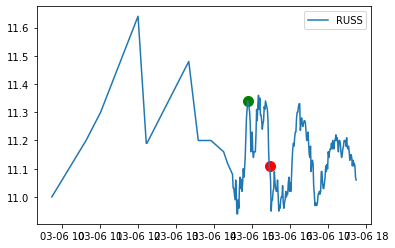

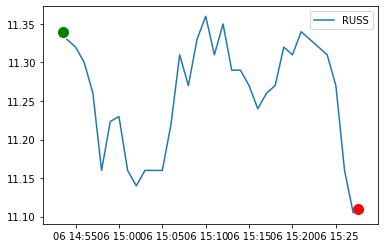

Delta = -0.23000000000000043


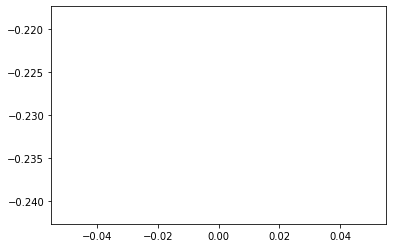

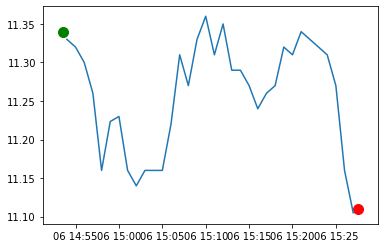

buy time:2020-03-06T14:53:32.330013806Z sell time:2020-03-06T15:27:30.871838268Z
{'rsi': 68.7765535377594, 'macd1': [0.13175208830397622, 0.1353024284379476, 0.14212617152367635, 0.14824589990681147, 0.15374430932485872], 'macd2': [0.1078645011639292, 0.11079060555003295, 0.11442507327103435, 0.11806570099312097, 0.1217061734379623], 'sell_macd': [0.07704067917788571, 0.07917675807113689, 0.08344932918183723, 0.08725328940859178, 0.09064269621634047], 'macd_signal': [0.13894692015403937, 0.13821802181082102, 0.13899965175339207, 0.14084890138407596, 0.14342798297223253], 'sell_macd_signal': [0.08300139177330096, 0.08223646503286815, 0.08247903786266196, 0.08343388817184792, 0.08487564978074644]}
{'rsi': 36.3474018147724, 'macd': [0.021941299078111598, 0.020523032740257463, 0.017073435168677875, 0.008449418422399546, -0.00045824941135386155], 'scalp': 0, 'bail_out': 0, 'movement': -0.019400352733686125, 'too_close': 1, 'macd_signal': [0.024711977533170885, 0.0238741885745882, 0.02251403

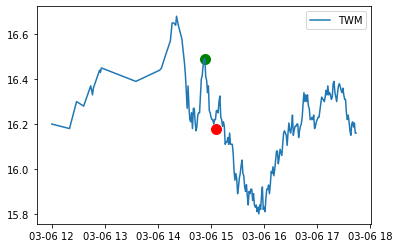

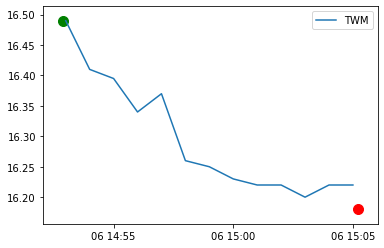

Delta = -0.3099999999999987


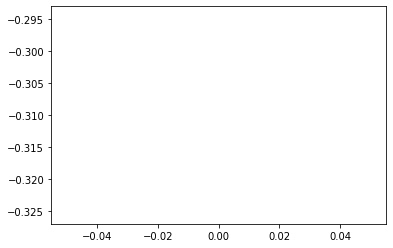

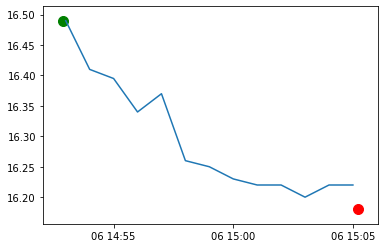

buy time:2020-03-06T14:52:52.835664811Z sell time:2020-03-06T15:05:11.970424381Z
{'rsi': 63.96237310446187, 'macd1': [0.10762427864798241, 0.11346776988514051, 0.11794950495830037, 0.12370642554315836, 0.12920023596670305], 'macd2': [0.07734156649828705, 0.08061934110992475, 0.08374596326783568, 0.0872083278149276, 0.09073414449289885], 'sell_macd': [0.06308259093739821, 0.06671488153229177, 0.06945803158633623, 0.0730311610883625, 0.07642540276411935], 'macd_signal': [0.11739599033991144, 0.11661034624895725, 0.11687817799082587, 0.11824382750129236, 0.1204351091943745], 'sell_macd_signal': [0.07081806750018185, 0.06999743030660384, 0.06988955056255032, 0.07051787266771276, 0.07169937868699408]}
{'rsi': 38.44933944908907, 'macd': [0.020853716194920935, 0.014597786553583347, 0.008494493501196132, 0.0046673236746421765, -0.00045342325091013436], 'scalp': 0, 'bail_out': 0, 'movement': -0.018799272286234004, 'too_close': 0, 'macd_signal': [0.045978912731016355, 0.039702687495529757, 0.033

In [91]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

